# Model Optimization

Notebook for optimizing tested models

### Imports

In [2]:
from utils.EDA_utils import *
from utils.utils import get_dataset
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import LinearSegmentedColormap
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NeighbourhoodCleaningRule
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, GroupKFold, GridSearchCV, LeaveOneOut
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.naive_bayes import GaussianNB
import dalex as dx
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.ensemble import EasyEnsembleClassifier
import warnings
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

In [3]:
warnings.filterwarnings("ignore")

## Main Training Loop

### Data Import

In [72]:
EE15 = get_dataset("data/", samples=["EE_015"], file_type="both", option_csq="potential", 
            options_genotype=["potential", "all"], with_default=True)
EE50 = get_dataset("data/", samples=["EE_050"], file_type="both", option_csq="potential", 
            options_genotype=["potential", "all"], with_default=True)
EE69 = get_dataset("data/", samples=["EE_069"], file_type="both", option_csq="potential", 
            options_genotype=["potential", "all"], with_default=True)

In [73]:
EE15['patient'] = 'EE15'
EE50['patient'] = 'EE50'
EE69['patient'] = 'EE69'

In [74]:
custom_mapping = {
    'Benign': 0,
    'Likely%40Benign': 1,
    'Uncertain%40Significance': 2,
    'Likely%40Pathogenic': 3,
    'Pathogenic': 4
}

target_column = "ACMG_class"
df = pd.concat([EE15, EE50, EE69])

df = df.loc[:, ~df.columns.duplicated()]
preprocessed_df = preprocess(df)

encoded_df, encoders, target_mapping = encode(preprocessed_df, target_column, custom_mapping)

In [11]:
def invert_dict(original_dict):
    inverted_dict = {v: k for k, v in original_dict.items()}
    return inverted_dict

In [12]:
def count_unique(arr):
    unique_values, counts = np.unique(arr, return_counts=True)
    for value, count in zip(unique_values, counts):
        print(f"Value {value} occurs {count} times.")

In [77]:
inverted_mapping = invert_dict(target_mapping)

### Cost Matrixes

In [78]:
cost_matrix = np.array([
    [0, 1, 3, 5, 6], #B
    [1, 0, 3, 5, 6], #LB
    [5, 3, 0, 1, 2], #US
    [10, 7, 5, 0, 1], #LP
    [12, 10, 5, 1, 0]  #P
], dtype = np.float64)

In [79]:
class_weights = []
for i in range(5):
    count = encoded_df["ACMG_class"].value_counts().get(i, 0)
    class_weights.append(count)
class_weights = np.array(class_weights, dtype=np.float64)
class_weights -= np.sum(class_weights)
class_weights *= (-1)
class_weights /= np.max(class_weights)
weighted_cost_matrix = cost_matrix * class_weights[:, np.newaxis]
weighted_cost_matrix

array([[ 0.        ,  0.13464403,  0.4039321 ,  0.67322016,  0.80786419],
       [ 0.94215944,  0.        ,  2.82647831,  4.71079718,  5.65295661],
       [ 4.61906551,  2.77143931,  0.        ,  0.9238131 ,  1.84762621],
       [ 9.99833481,  6.99883437,  4.99916741,  0.        ,  0.99983348],
       [12.        , 10.        ,  5.        ,  1.        ,  0.        ]])

In [80]:
def custom_loss_func(y_true, y_pred):
    return np.sum(cost_matrix[y_true, y_pred])

def custom_loss_func_weighted(y_true, y_pred):
    return np.sum(weighted_cost_matrix[y_true, y_pred])

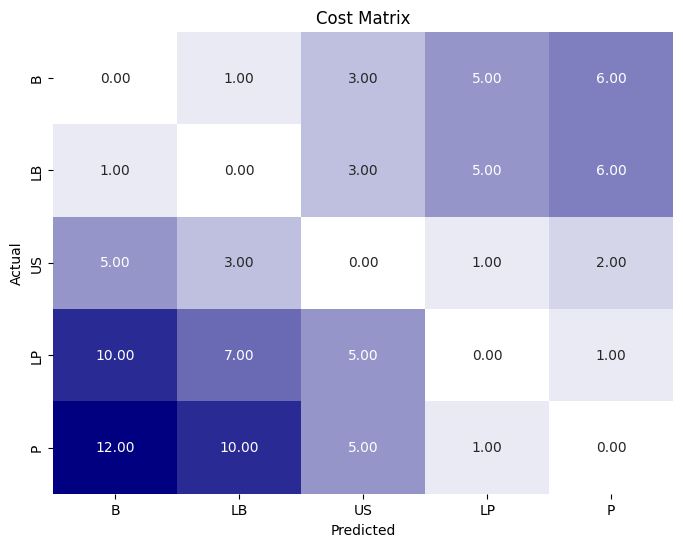

In [81]:
class_names = ['B', 'LB', 'US', 'LP', 'P']

colors = [(1, 1, 1), (0, 0, 0.5)]
cmap = LinearSegmentedColormap.from_list('custom_blue', colors, N=256)
plt.figure(figsize=(8, 6))
sns.heatmap(cost_matrix, annot=True, fmt=".2f", cmap=cmap,
            xticklabels=class_names, yticklabels=class_names, cbar=False)

plt.title('Cost Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

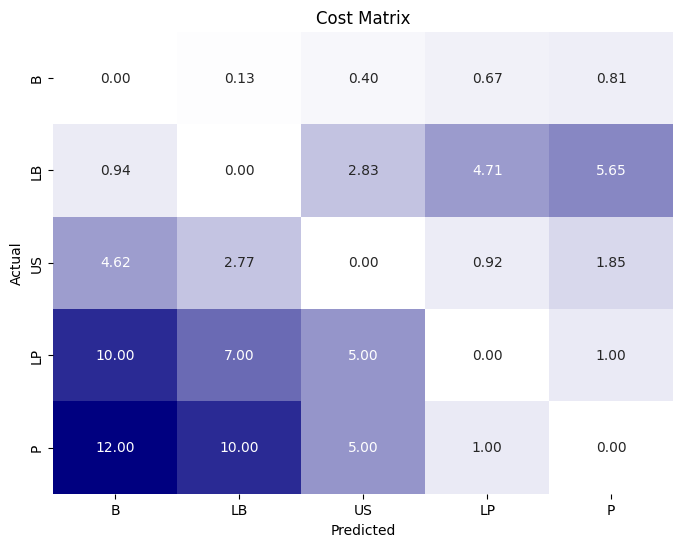

In [82]:
class_names = ['B', 'LB', 'US', 'LP', 'P']

colors = [(1, 1, 1), (0, 0, 0.5)]
cmap = LinearSegmentedColormap.from_list('custom_blue', colors, N=256)
plt.figure(figsize=(8, 6))
sns.heatmap(weighted_cost_matrix, annot=True, fmt=".2f", cmap=cmap,
            xticklabels=class_names, yticklabels=class_names, cbar=False)

plt.title('Cost Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Model Training

#### Creating Training, Validation and Test sets

In [83]:
encoded_df = encoded_df.drop_duplicates()
test_patient = encoded_df[encoded_df['patient'] == 0].copy()
test_patient = test_patient.sample(frac=1, random_state=42).reset_index(drop=True)
encoded_df = encoded_df[encoded_df['patient'] != 0]

X_test = test_patient.drop(columns=["patient", target_column])
y_test = test_patient[target_column]

X = encoded_df.drop(columns = ["patient", target_column])
y = encoded_df[target_column]

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

#### Logistic Regression

Fitting Model with unweighted loss, greater==better: False, None
Best Parameters:  {'solver': 'lbfgs', 'penalty': None, 'max_iter': 300}
Best Custom Score:  -171.8
Confusion Matrix:


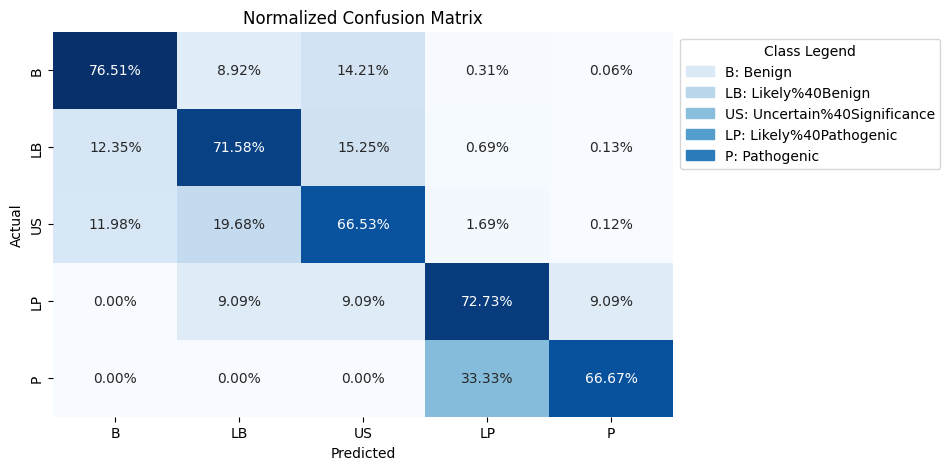

Fitting Model with weighted loss, greater==better: False, None
Best Parameters:  {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 500}
Best Custom Score:  -61.53408596875746
Confusion Matrix:


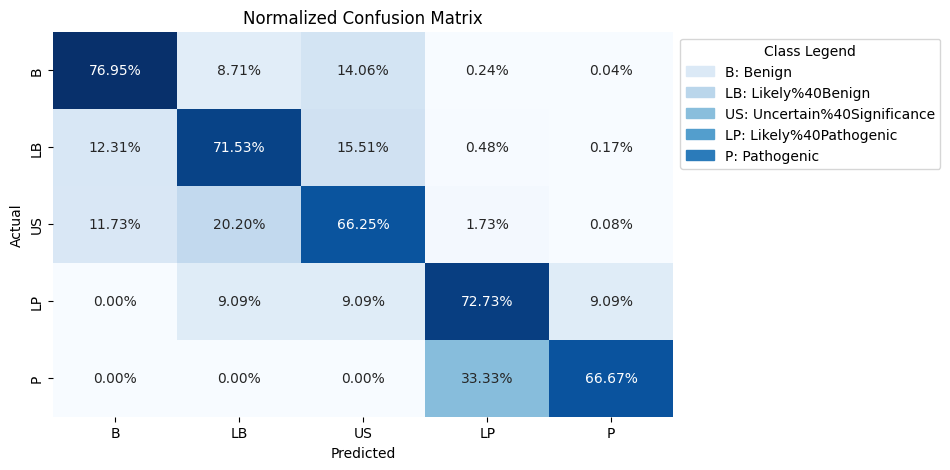

Fitting Model with unweighted loss, greater==better: False, Random OverSampler
Best Parameters:  {'solver': 'lbfgs', 'penalty': None, 'max_iter': 500}
Best Custom Score:  -203.0
Confusion Matrix:


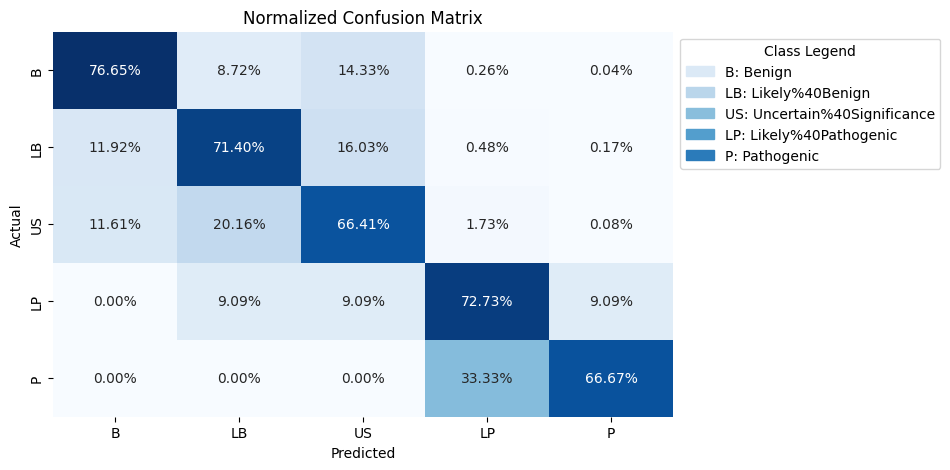

Fitting Model with weighted loss, greater==better: False, Random OverSampler
Best Parameters:  {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 500}
Best Custom Score:  -86.22793332043189
Confusion Matrix:


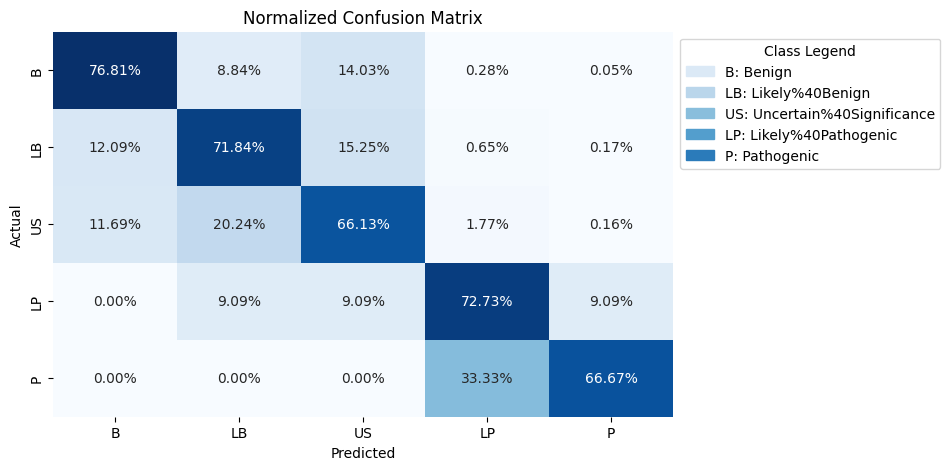

Fitting Model with unweighted loss, greater==better: False, Random UnderSampling
Best Parameters:  {'solver': 'lbfgs', 'penalty': None, 'max_iter': 500}
Best Custom Score:  -220.6
Confusion Matrix:


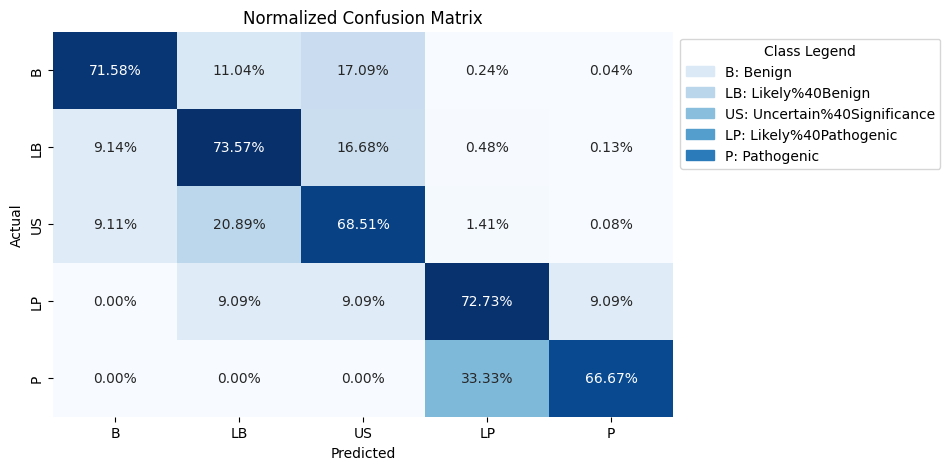

Fitting Model with weighted loss, greater==better: False, Random UnderSampling
Best Parameters:  {'solver': 'lbfgs', 'penalty': None, 'max_iter': 200}
Best Custom Score:  -79.76565840222865
Confusion Matrix:


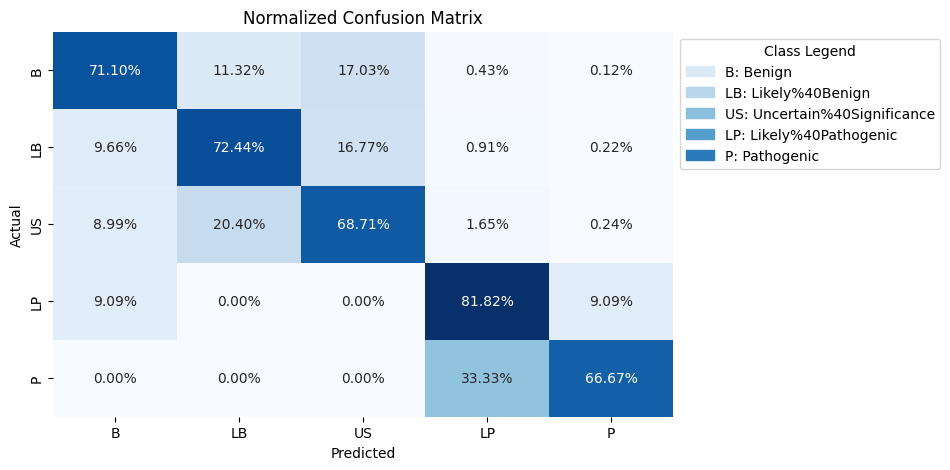

Fitting Model with unweighted loss, greater==better: False, SMOTE
Best Parameters:  {'solver': 'lbfgs', 'penalty': None, 'max_iter': 500}
Best Custom Score:  -203.0
Confusion Matrix:


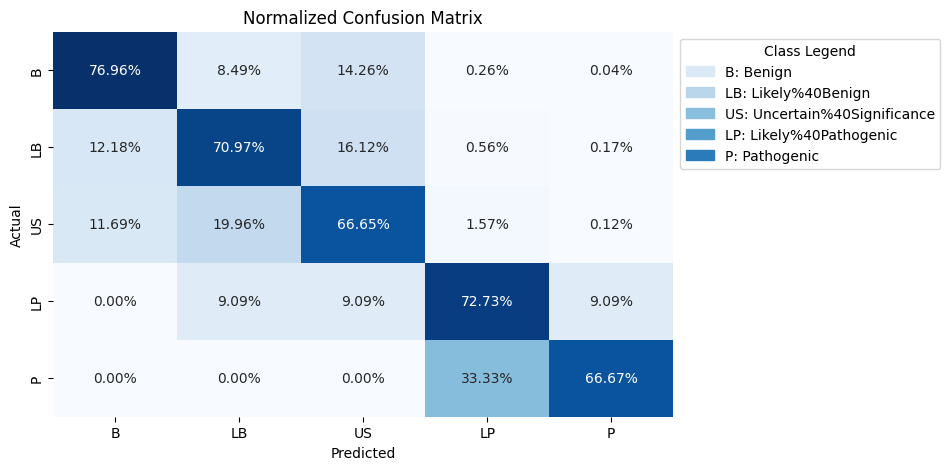

Fitting Model with weighted loss, greater==better: False, SMOTE
Best Parameters:  {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 500}
Best Custom Score:  -86.22793332043189
Confusion Matrix:


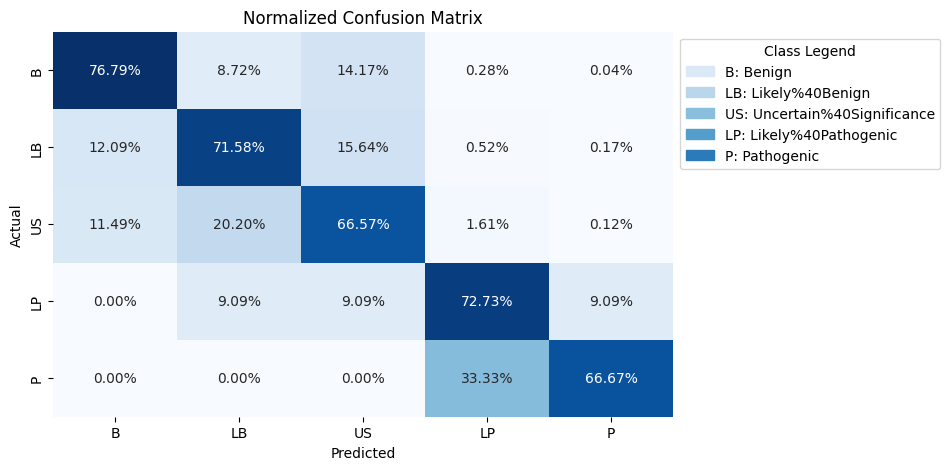

Fitting Model with unweighted loss, greater==better: False, SMOTE with cleaning
Best Parameters:  {'solver': 'newton-cg', 'penalty': None, 'max_iter': 200}
Best Custom Score:  -52.6
Confusion Matrix:


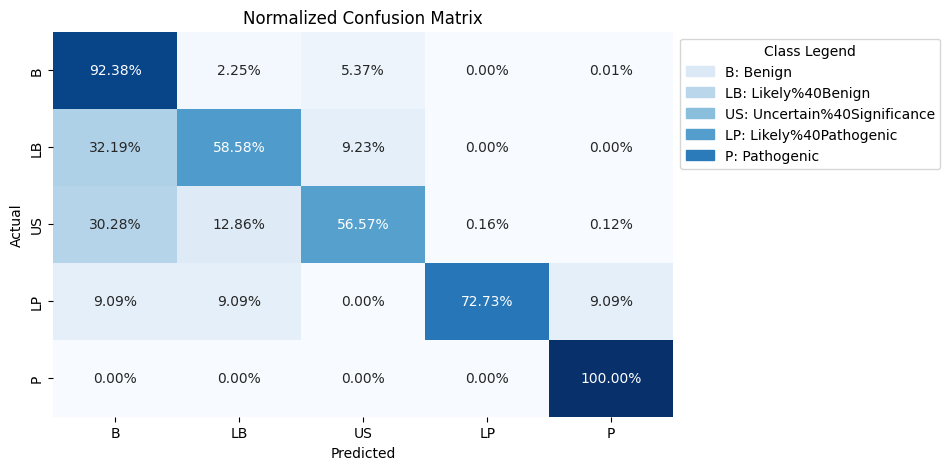

Fitting Model with weighted loss, greater==better: False, SMOTE with cleaning
Best Parameters:  {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 300}
Best Custom Score:  -28.416300400095412
Confusion Matrix:


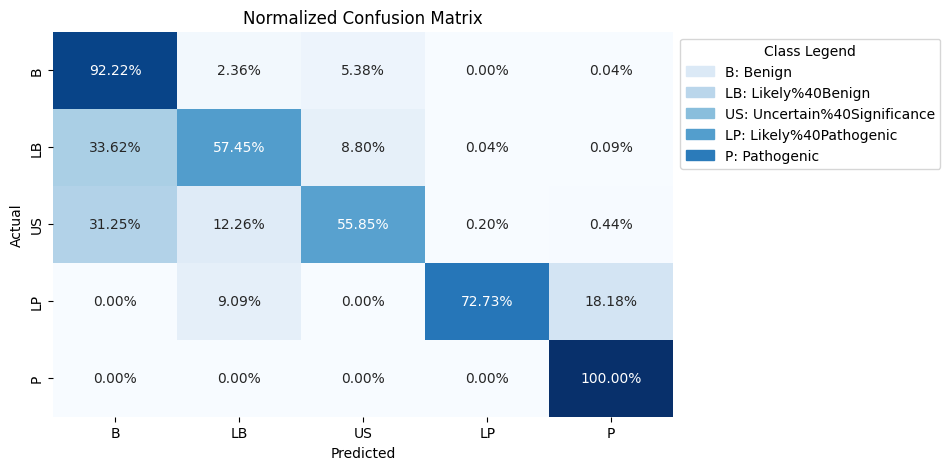

In [16]:
losses = [("unweighted", custom_loss_func), ("weighted", custom_loss_func_weighted)]

greater_better = False
classes_to_oversample = [3, 4]
classes_to_undersample = [0]
undersampling_ratios = [200000]
sampling_ratios = [150, 60]

methods = [
    ("None", None, None),
    ("Random OverSampler" , RandomOverSampler(sampling_strategy={class_label: ratio for class_label, ratio in zip(classes_to_oversample, sampling_ratios)}, random_state=42), None),
    ("Random UnderSampling", RandomUnderSampler(sampling_strategy={class_label: ratio for class_label, ratio in zip(classes_to_undersample, undersampling_ratios)}, random_state=42), RandomOverSampler(sampling_strategy={class_label: ratio for class_label, ratio in zip(classes_to_oversample, sampling_ratios)}, random_state=42)),
    ("SMOTE", SMOTE(sampling_strategy={class_label: ratio for class_label, ratio in zip(classes_to_oversample, sampling_ratios)}, random_state=42), None),
    ("SMOTE with cleaning", SMOTE(sampling_strategy={class_label: ratio for class_label, ratio in zip(classes_to_oversample, sampling_ratios)}, random_state=42), NeighbourhoodCleaningRule(sampling_strategy='auto', n_neighbors=7)),
]

param_grid = {
    'penalty': ['l2', 'elasticnet', None],
    'solver': ['lbfgs', 'newton-cg', 'saga'],
    'max_iter': [5, 20, 100, 200, 300, 500]
}

for method_name, method, neighborhood_cleaning in methods:
    for loss_name, my_loss in losses:
        print(f"Fitting Model with {loss_name} loss, greater==better: {greater_better}, {method_name}")

        custom_scorer = make_scorer(my_loss, greater_is_better=greater_better)
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        classifier = LogisticRegression(class_weight=dict(enumerate(class_weights)), random_state=42)

        if method_name == 'None':
            X_resampled_cleaned, y_resampled_cleaned = X_train, y_train

        elif method_name == "SMOTE with cleaning":
            X_resampled, y_resampled = method.fit_resample(X_train, y_train)
            X_resampled_cleaned, y_resampled_cleaned = neighborhood_cleaning.fit_resample(X_resampled, y_resampled)

        elif method_name == "Random UnderSampling":
            X_resampled, y_resampled = method.fit_resample(X_train, y_train)
            X_resampled_cleaned, y_resampled_cleaned = neighborhood_cleaning.fit_resample(X_resampled, y_resampled)
            
        else:
            X_resampled_cleaned, y_resampled_cleaned = method.fit_resample(X_train, y_train)

        stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        halving_search = HalvingRandomSearchCV(
            classifier,
            param_distributions=param_grid,
            scoring=custom_scorer,
            cv=stratified_kfold,
            factor=2,
            resource='n_samples',
            random_state=42
        )

        halving_search.fit(X_resampled_cleaned, y_resampled_cleaned)

        print("Best Parameters: ", halving_search.best_params_)
        print("Best Custom Score: ", halving_search.best_score_)
        print("Confusion Matrix:")

        best_params = halving_search.best_params_
        best_classifier = LogisticRegression(**best_params, class_weight=dict(enumerate(class_weights)), random_state=42)
        best_classifier.fit(X_resampled_cleaned, y_resampled_cleaned)
        y_pred = best_classifier.predict(X_val)
        get_confusion_matrix_plot(y_val, y_pred, inverted_mapping)

### DecisionTree

Fitting Model with unweighted loss, greater==better: False, None
Best Parameters:  {'max_depth': 20, 'criterion': 'gini'}
Best Custom Score:  -59.2
Confusion Matrix:


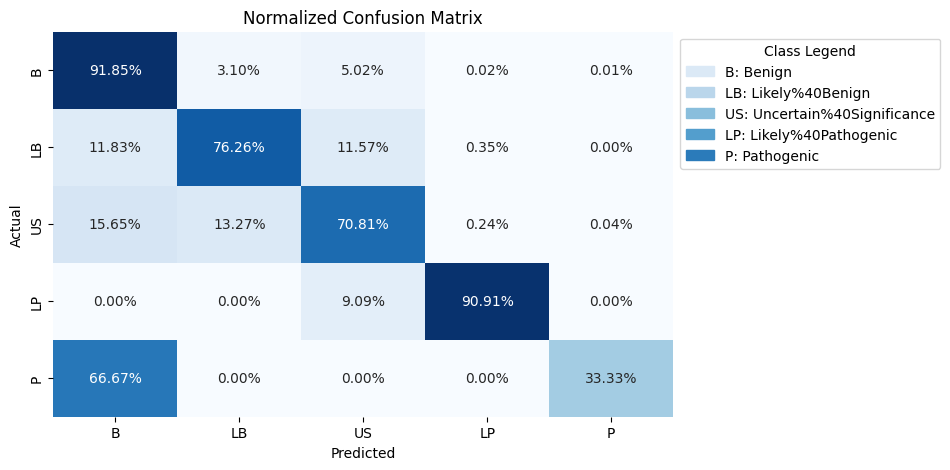

Fitting Model with weighted loss, greater==better: False, None
Best Parameters:  {'max_depth': None, 'criterion': 'gini'}
Best Custom Score:  -33.72713718006993
Confusion Matrix:


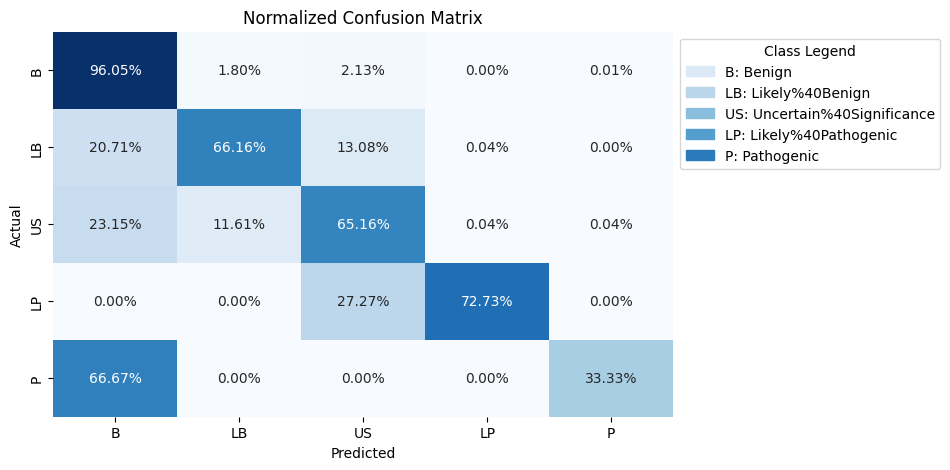

Fitting Model with unweighted loss, greater==better: False, Random OverSampler
Best Parameters:  {'max_depth': 1000, 'criterion': 'entropy'}
Best Custom Score:  -60.2
Confusion Matrix:


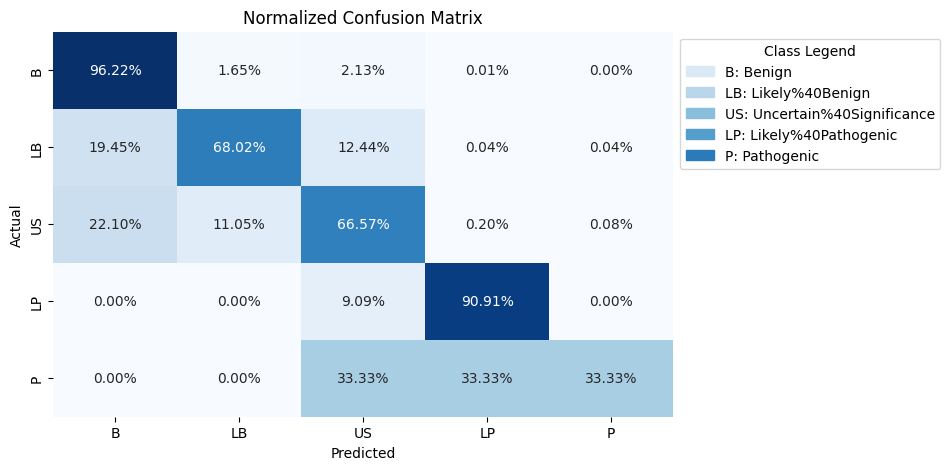

Fitting Model with weighted loss, greater==better: False, Random OverSampler
Best Parameters:  {'max_depth': 1000, 'criterion': 'entropy'}
Best Custom Score:  -40.14577964598982
Confusion Matrix:


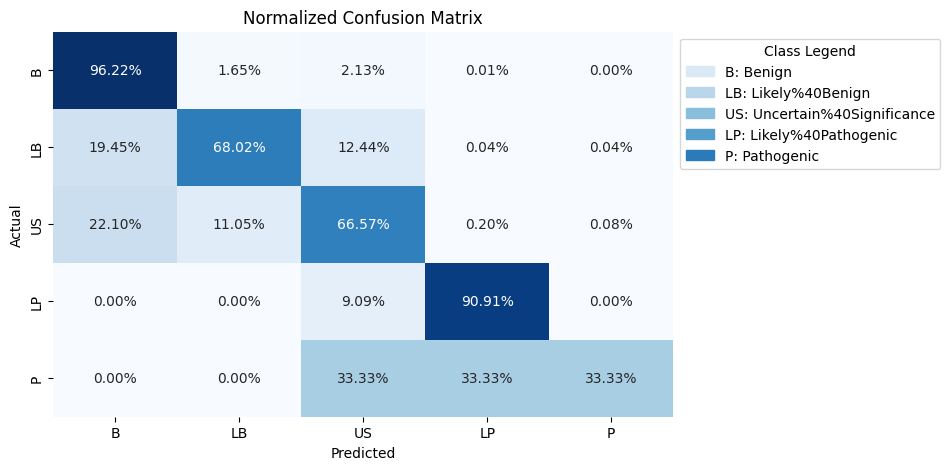

Fitting Model with unweighted loss, greater==better: False, Random UnderSampling
Best Parameters:  {'max_depth': 1000, 'criterion': 'entropy'}
Best Custom Score:  -65.0
Confusion Matrix:


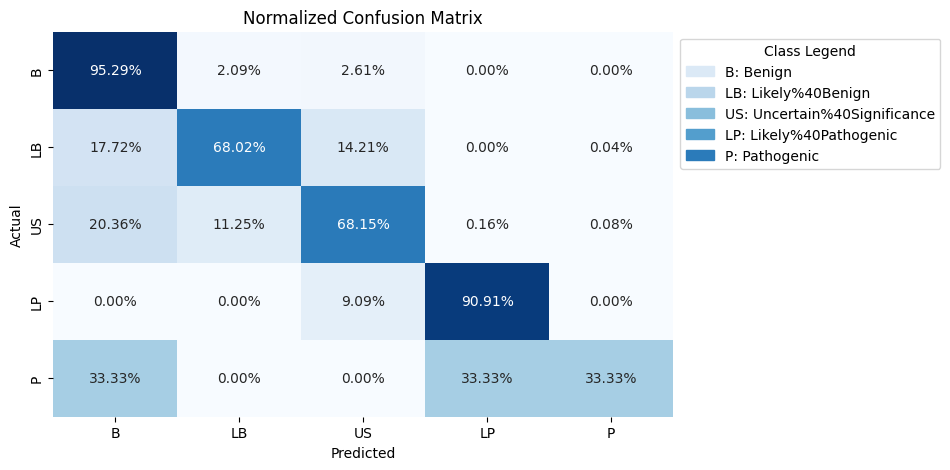

Fitting Model with weighted loss, greater==better: False, Random UnderSampling
Best Parameters:  {'max_depth': 1000, 'criterion': 'entropy'}
Best Custom Score:  -40.78106320067328
Confusion Matrix:


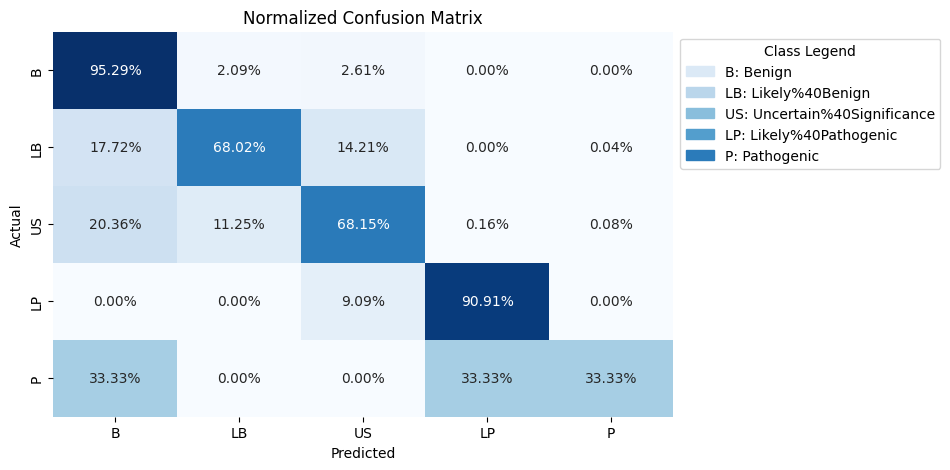

Fitting Model with unweighted loss, greater==better: False, SMOTE
Best Parameters:  {'max_depth': 1000, 'criterion': 'entropy'}
Best Custom Score:  -60.2
Confusion Matrix:


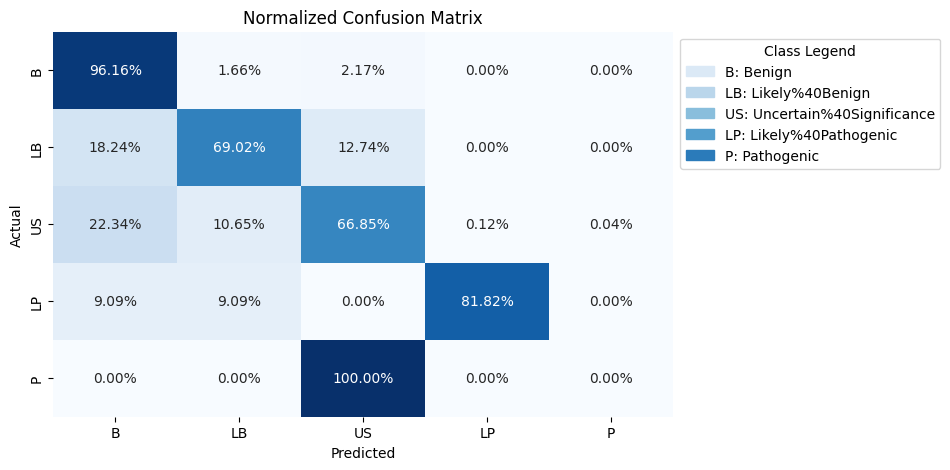

Fitting Model with weighted loss, greater==better: False, SMOTE
Best Parameters:  {'max_depth': 1000, 'criterion': 'entropy'}
Best Custom Score:  -40.14577964598982
Confusion Matrix:


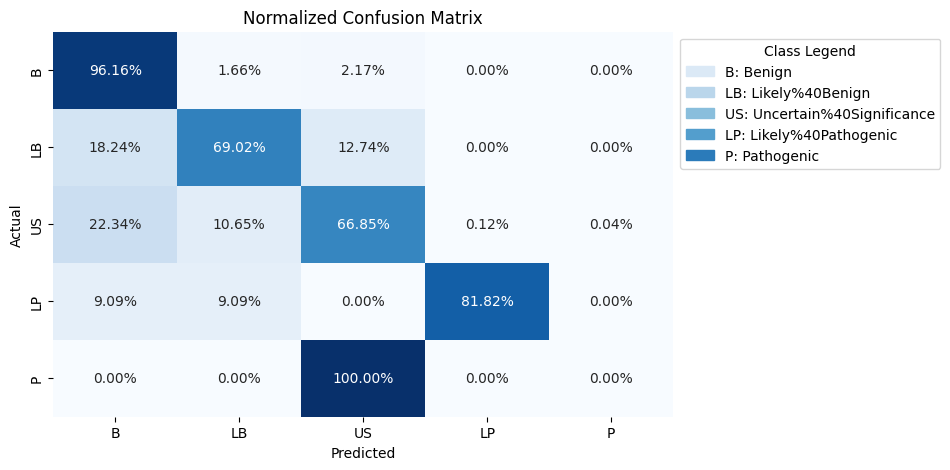

Fitting Model with unweighted loss, greater==better: False, SMOTE with cleaning
Best Parameters:  {'max_depth': None, 'criterion': 'gini'}
Best Custom Score:  -29.2
Confusion Matrix:


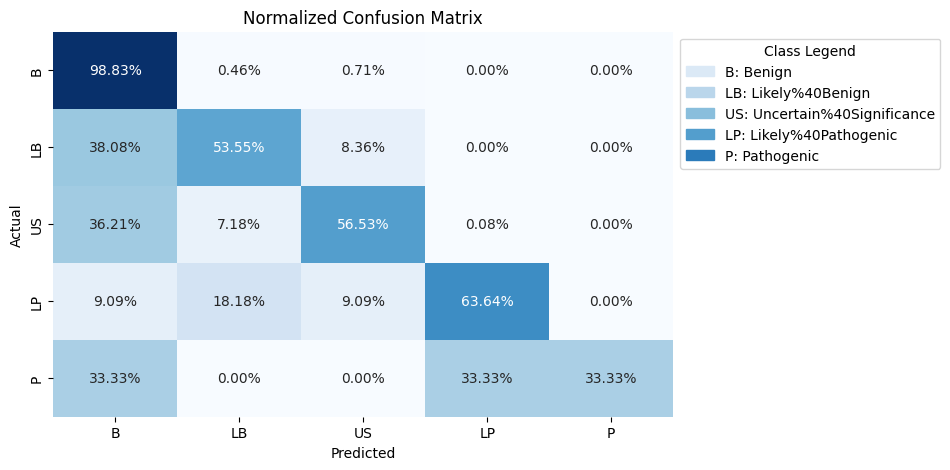

Fitting Model with weighted loss, greater==better: False, SMOTE with cleaning
Best Parameters:  {'max_depth': None, 'criterion': 'entropy'}
Best Custom Score:  -20.050042979878214
Confusion Matrix:


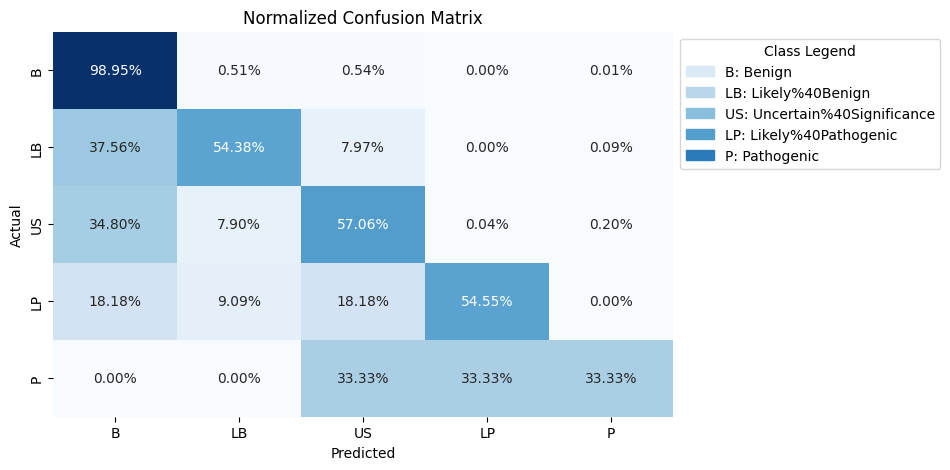

In [17]:
losses = [("unweighted", custom_loss_func), ("weighted", custom_loss_func_weighted)]

greater_better = False
classes_to_oversample = [3, 4]
classes_to_undersample = [0]
undersampling_ratios = [200000]
sampling_ratios = [150, 60]

methods = [
    ("None", None, None),
    ("Random OverSampler" , RandomOverSampler(sampling_strategy={class_label: ratio for class_label, ratio in zip(classes_to_oversample, sampling_ratios)}, random_state=42), None),
    ("Random UnderSampling", RandomUnderSampler(sampling_strategy={class_label: ratio for class_label, ratio in zip(classes_to_undersample, undersampling_ratios)}, random_state=42), RandomOverSampler(sampling_strategy={class_label: ratio for class_label, ratio in zip(classes_to_oversample, sampling_ratios)}, random_state=42)),
    ("SMOTE", SMOTE(sampling_strategy={class_label: ratio for class_label, ratio in zip(classes_to_oversample, sampling_ratios)}, random_state=42), None),
    ("SMOTE with cleaning", SMOTE(sampling_strategy={class_label: ratio for class_label, ratio in zip(classes_to_oversample, sampling_ratios)}, random_state=42), NeighbourhoodCleaningRule(sampling_strategy='auto', n_neighbors=7)),
]

param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 10, 20, 100, 1000, 10000]
}

for method_name, method, neighborhood_cleaning in methods:
    for loss_name, my_loss in losses:
        print(f"Fitting Model with {loss_name} loss, greater==better: {greater_better}, {method_name}")

        custom_scorer = make_scorer(my_loss, greater_is_better=greater_better)
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        classifier = DecisionTreeClassifier(class_weight=dict(enumerate(class_weights)), random_state=42)

        if method_name == 'None':
            X_resampled_cleaned, y_resampled_cleaned = X_train, y_train

        elif method_name == "SMOTE with cleaning":
            X_resampled, y_resampled = method.fit_resample(X_train, y_train)
            X_resampled_cleaned, y_resampled_cleaned = neighborhood_cleaning.fit_resample(X_resampled, y_resampled)

        elif method_name == "Random UnderSampling":
            X_resampled, y_resampled = method.fit_resample(X_train, y_train)
            X_resampled_cleaned, y_resampled_cleaned = neighborhood_cleaning.fit_resample(X_resampled, y_resampled)
            
        else:
            X_resampled_cleaned, y_resampled_cleaned = method.fit_resample(X_train, y_train)

        stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        halving_search = HalvingRandomSearchCV(
            classifier,
            param_distributions=param_grid,
            scoring=custom_scorer,
            cv=stratified_kfold,
            factor=2,
            resource='n_samples',
            random_state=42
        )

        halving_search.fit(X_resampled_cleaned, y_resampled_cleaned)

        print("Best Parameters: ", halving_search.best_params_)
        print("Best Custom Score: ", halving_search.best_score_)
        print("Confusion Matrix:")

        best_params = halving_search.best_params_
        best_classifier = DecisionTreeClassifier(**best_params, class_weight=dict(enumerate(class_weights)), random_state=42)
        best_classifier.fit(X_resampled_cleaned, y_resampled_cleaned)
        y_pred = best_classifier.predict(X_val)
        get_confusion_matrix_plot(y_val, y_pred, inverted_mapping)

#### AdaBoost

Fitting Model with unweighted loss, greater==better: False, None
Best Parameters:  {'n_estimators': 20, 'learning_rate': 0.1, 'estimator': None}
Best Custom Score:  -95.4
Confusion Matrix:


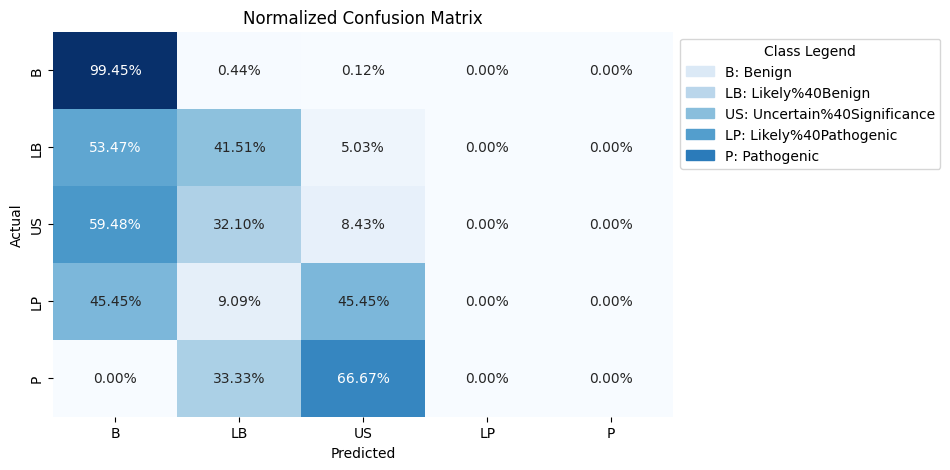

Fitting Model with weighted loss, greater==better: False, None
Best Parameters:  {'n_estimators': 100, 'learning_rate': 10, 'estimator': None}
Best Custom Score:  -101.90021647456987
Confusion Matrix:


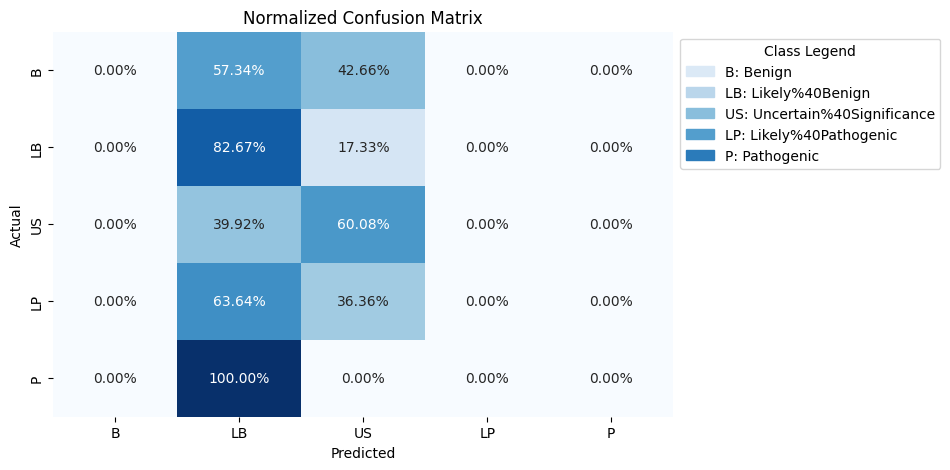

Fitting Model with unweighted loss, greater==better: False, Random OverSampler
Best Parameters:  {'n_estimators': 10, 'learning_rate': 0.1, 'estimator': None}
Best Custom Score:  -136.8
Confusion Matrix:


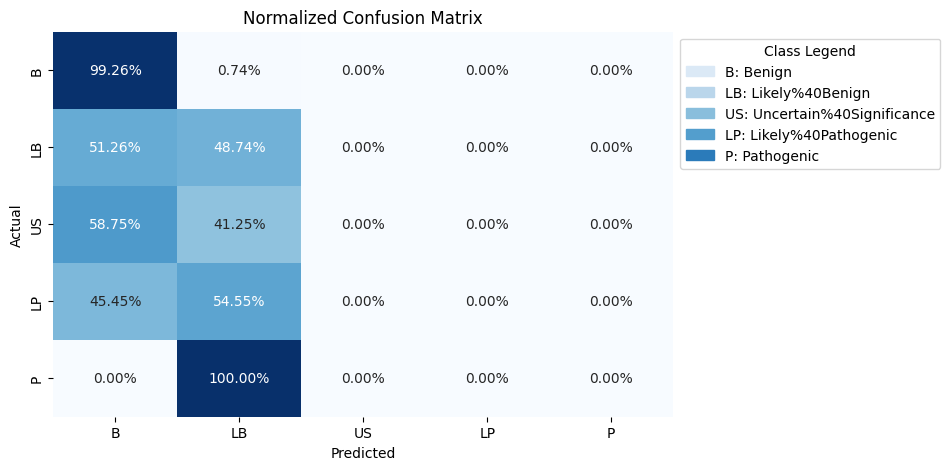

Fitting Model with weighted loss, greater==better: False, Random OverSampler
Best Parameters:  {'n_estimators': 10, 'learning_rate': 1, 'estimator': None}
Best Custom Score:  -102.5084492589909
Confusion Matrix:


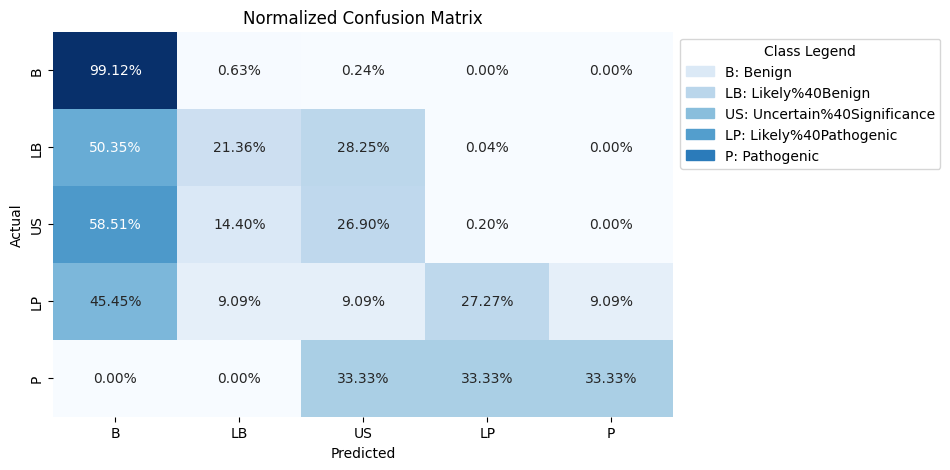

Fitting Model with unweighted loss, greater==better: False, Random UnderSampling
Best Parameters:  {'n_estimators': 10, 'learning_rate': 0.1, 'estimator': LogisticRegression(random_state=42)}
Best Custom Score:  -163.2
Confusion Matrix:


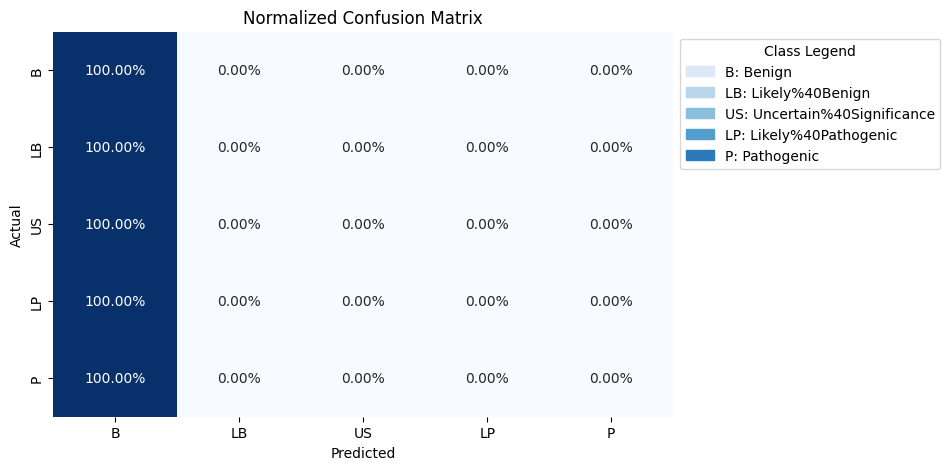

Fitting Model with weighted loss, greater==better: False, Random UnderSampling
Best Parameters:  {'n_estimators': 50, 'learning_rate': 0.1, 'estimator': None}
Best Custom Score:  -119.97338172882624
Confusion Matrix:


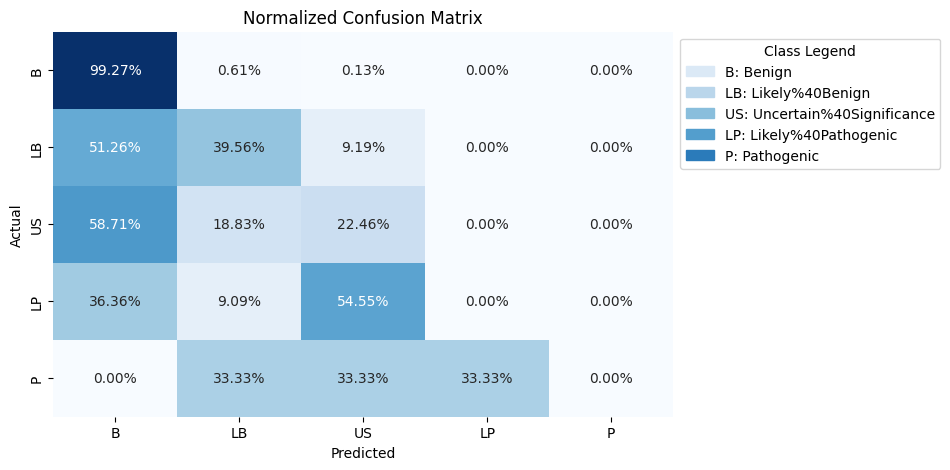

Fitting Model with unweighted loss, greater==better: False, SMOTE
Best Parameters:  {'n_estimators': 10, 'learning_rate': 0.1, 'estimator': None}
Best Custom Score:  -136.8
Confusion Matrix:


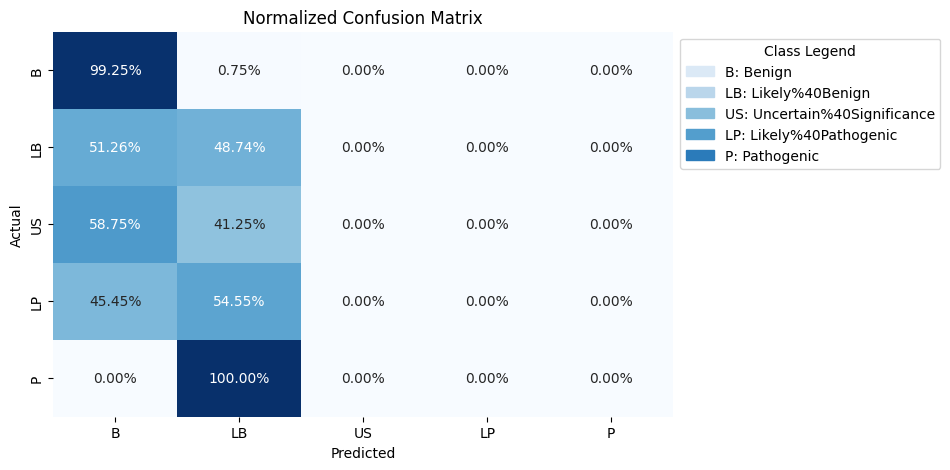

Fitting Model with weighted loss, greater==better: False, SMOTE
Best Parameters:  {'n_estimators': 10, 'learning_rate': 1, 'estimator': None}
Best Custom Score:  -102.5084492589909
Confusion Matrix:


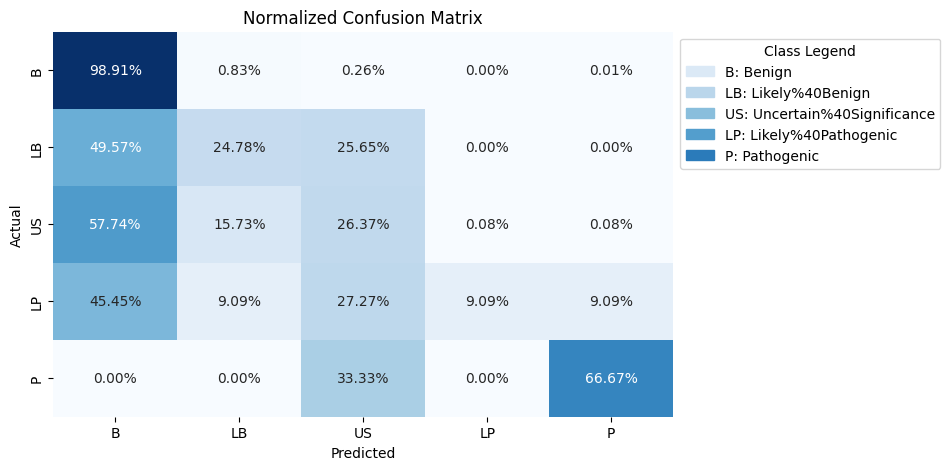

Fitting Model with unweighted loss, greater==better: False, SMOTE with cleaning
Best Parameters:  {'n_estimators': 200, 'learning_rate': 0.1, 'estimator': None}
Best Custom Score:  -99.2
Confusion Matrix:


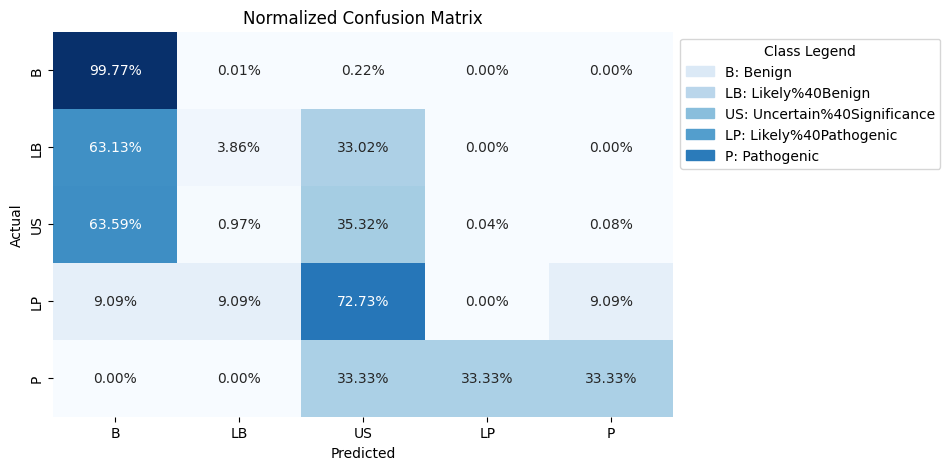

Fitting Model with weighted loss, greater==better: False, SMOTE with cleaning
Best Parameters:  {'n_estimators': 20, 'learning_rate': 10, 'estimator': None}
Best Custom Score:  -60.979946623941814
Confusion Matrix:


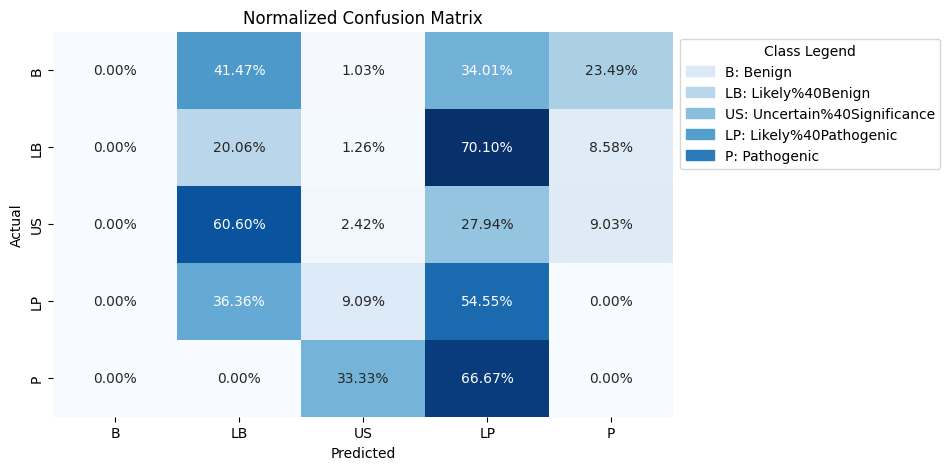

In [18]:
losses = [("unweighted", custom_loss_func), ("weighted", custom_loss_func_weighted)]

greater_better = False
classes_to_oversample = [3, 4]
classes_to_undersample = [0]
undersampling_ratios = [200000]
sampling_ratios = [150, 60]

methods = [
    ("None", None, None),
    ("Random OverSampler" , RandomOverSampler(sampling_strategy={class_label: ratio for class_label, ratio in zip(classes_to_oversample, sampling_ratios)}, random_state=42), None),
    ("Random UnderSampling", RandomUnderSampler(sampling_strategy={class_label: ratio for class_label, ratio in zip(classes_to_undersample, undersampling_ratios)}, random_state=42), RandomOverSampler(sampling_strategy={class_label: ratio for class_label, ratio in zip(classes_to_oversample, sampling_ratios)}, random_state=42)),
    ("SMOTE", SMOTE(sampling_strategy={class_label: ratio for class_label, ratio in zip(classes_to_oversample, sampling_ratios)}, random_state=42), None),
    ("SMOTE with cleaning", SMOTE(sampling_strategy={class_label: ratio for class_label, ratio in zip(classes_to_oversample, sampling_ratios)}, random_state=42), NeighbourhoodCleaningRule(sampling_strategy='auto', n_neighbors=7)),
]

param_grid = {
    'estimator': [None, LogisticRegression(random_state=42)],
    'n_estimators': [10, 20, 50, 100, 200],
    'learning_rate': [0.1, 1, 2, 10]
}

for method_name, method, neighborhood_cleaning in methods:
    for loss_name, my_loss in losses:
        print(f"Fitting Model with {loss_name} loss, greater==better: {greater_better}, {method_name}")

        custom_scorer = make_scorer(my_loss, greater_is_better=greater_better)
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        classifier = AdaBoostClassifier(random_state=42)

        if method_name == 'None':
            X_resampled_cleaned, y_resampled_cleaned = X_train, y_train

        elif method_name == "SMOTE with cleaning":
            X_resampled, y_resampled = method.fit_resample(X_train, y_train)
            X_resampled_cleaned, y_resampled_cleaned = neighborhood_cleaning.fit_resample(X_resampled, y_resampled)

        elif method_name == "Random UnderSampling":
            X_resampled, y_resampled = method.fit_resample(X_train, y_train)
            X_resampled_cleaned, y_resampled_cleaned = neighborhood_cleaning.fit_resample(X_resampled, y_resampled)
            
        else:
            X_resampled_cleaned, y_resampled_cleaned = method.fit_resample(X_train, y_train)

        stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        halving_search = HalvingRandomSearchCV(
            classifier,
            param_distributions=param_grid,
            scoring=custom_scorer,
            cv=stratified_kfold,
            factor=2,
            resource='n_samples',
            random_state=42
        )

        halving_search.fit(X_resampled_cleaned, y_resampled_cleaned)

        print("Best Parameters: ", halving_search.best_params_)
        print("Best Custom Score: ", halving_search.best_score_)
        print("Confusion Matrix:")

        best_params = halving_search.best_params_
        best_classifier = AdaBoostClassifier(**best_params, random_state=42)
        best_classifier.fit(X_resampled_cleaned, y_resampled_cleaned)
        y_pred = best_classifier.predict(X_val)
        get_confusion_matrix_plot(y_val, y_pred, inverted_mapping)

#### CatBoost

Fitting Model with unweighted loss, greater==better: False, None
Best Parameters:  {'verbose': False, 'learning_rate': 0.01, 'l2_leaf_reg': 10, 'depth': 10}
Best Custom Score:  -45887.8
Confusion Matrix:


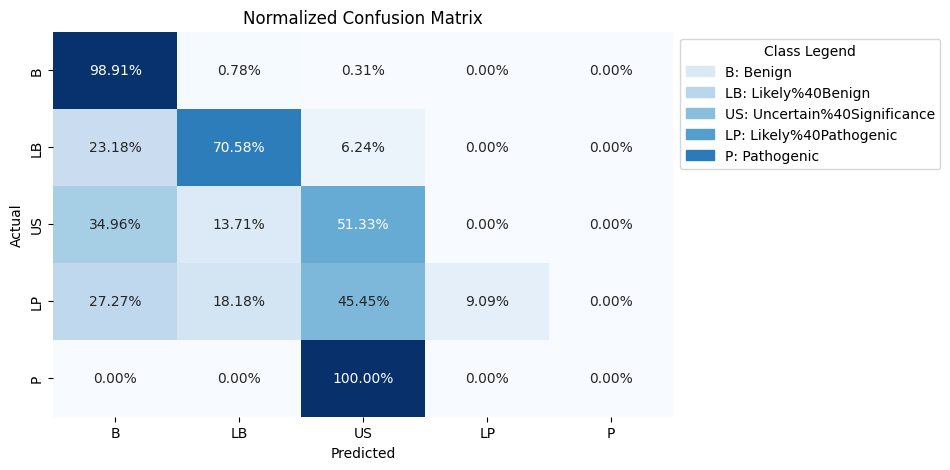

Fitting Model with weighted loss, greater==better: False, None
Best Parameters:  {'verbose': False, 'learning_rate': 0.01, 'l2_leaf_reg': 5, 'depth': 10}
Best Custom Score:  -36100.14947231511
Confusion Matrix:


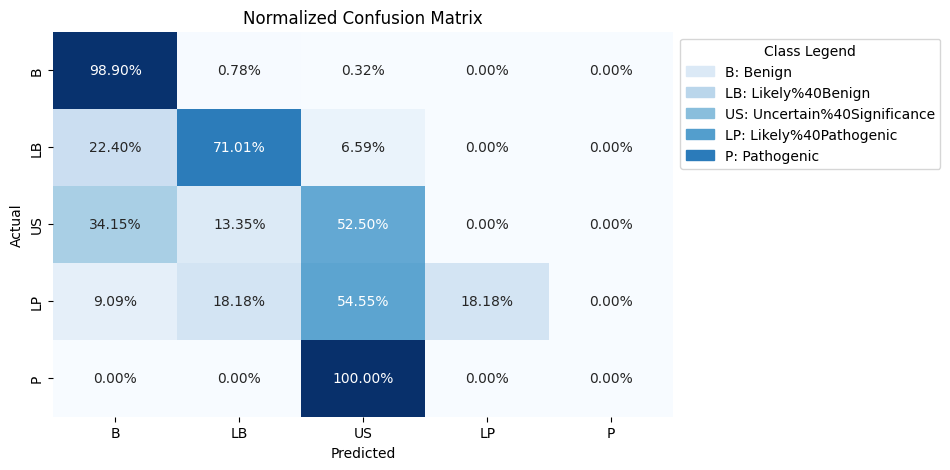

Fitting Model with unweighted loss, greater==better: False, Random OverSampler
Best Parameters:  {'verbose': False, 'learning_rate': 0.01, 'l2_leaf_reg': 5, 'depth': 8}
Best Custom Score:  -58510.4
Confusion Matrix:


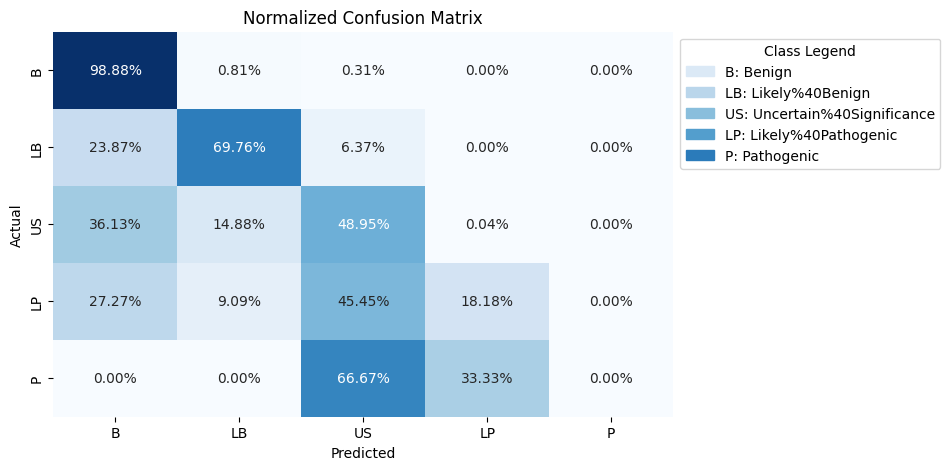

Fitting Model with weighted loss, greater==better: False, Random OverSampler
Best Parameters:  {'verbose': False, 'learning_rate': 0.01, 'l2_leaf_reg': 1, 'depth': 8}
Best Custom Score:  -45970.51488678965
Confusion Matrix:


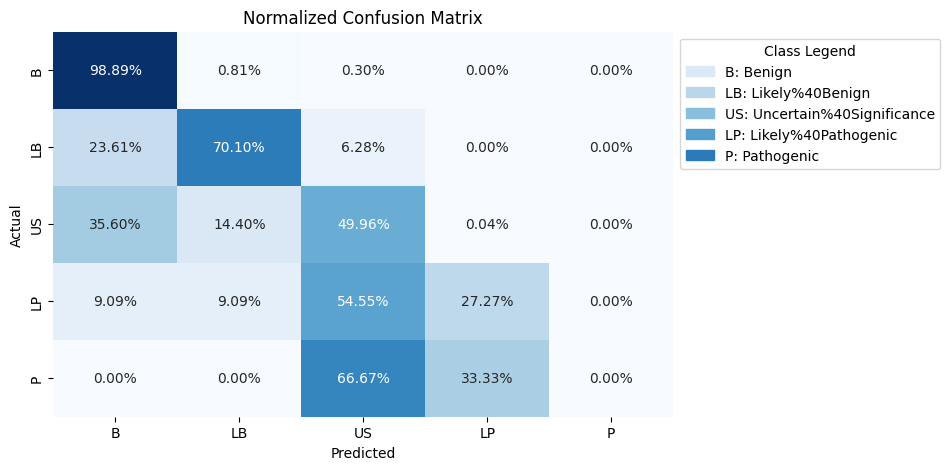

Fitting Model with unweighted loss, greater==better: False, Random UnderSampling
Best Parameters:  {'verbose': False, 'learning_rate': 0.01, 'l2_leaf_reg': 10, 'depth': 10}
Best Custom Score:  -62986.4
Confusion Matrix:


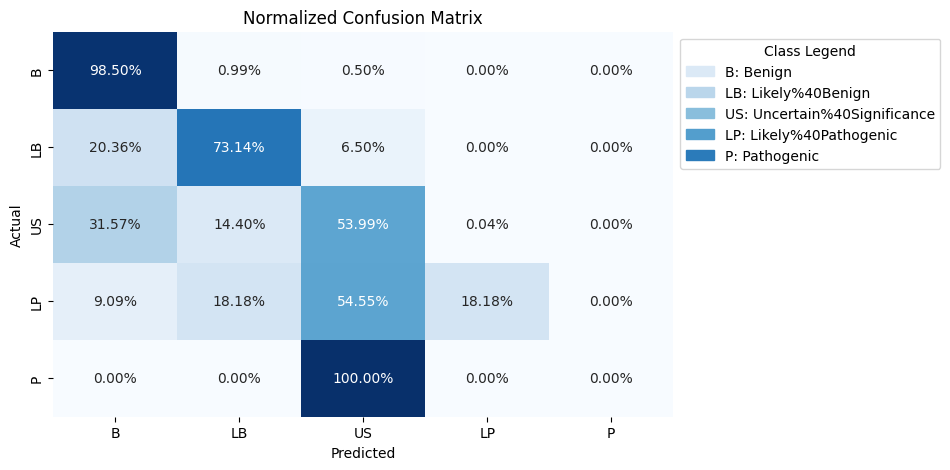

Fitting Model with weighted loss, greater==better: False, Random UnderSampling
Best Parameters:  {'verbose': False, 'learning_rate': 0.05, 'l2_leaf_reg': 1, 'depth': 8}
Best Custom Score:  -48012.022439996945
Confusion Matrix:


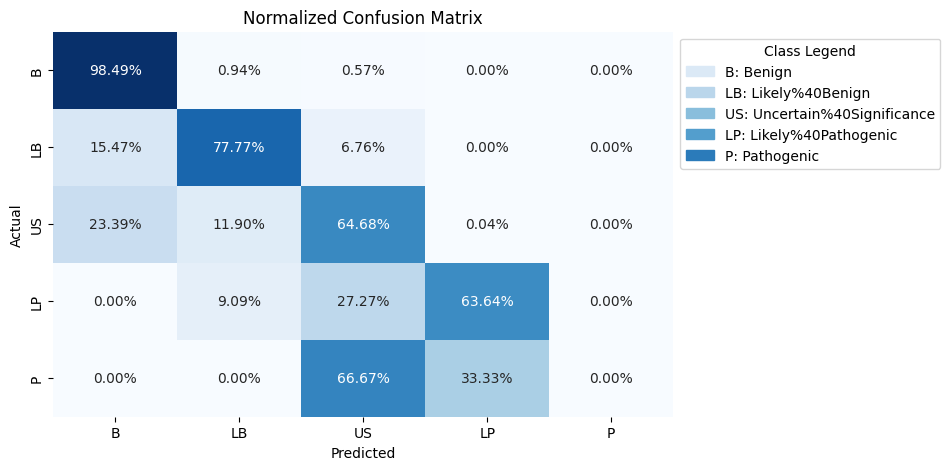

Fitting Model with unweighted loss, greater==better: False, SMOTE
Best Parameters:  {'verbose': False, 'learning_rate': 0.01, 'l2_leaf_reg': 5, 'depth': 8}
Best Custom Score:  -58510.4
Confusion Matrix:


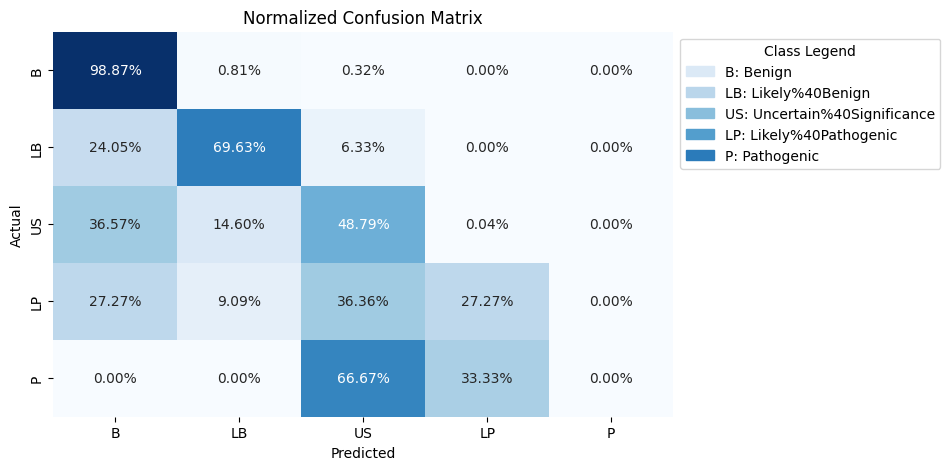

Fitting Model with weighted loss, greater==better: False, SMOTE
Best Parameters:  {'verbose': False, 'learning_rate': 0.01, 'l2_leaf_reg': 1, 'depth': 8}
Best Custom Score:  -45970.51488678965
Confusion Matrix:


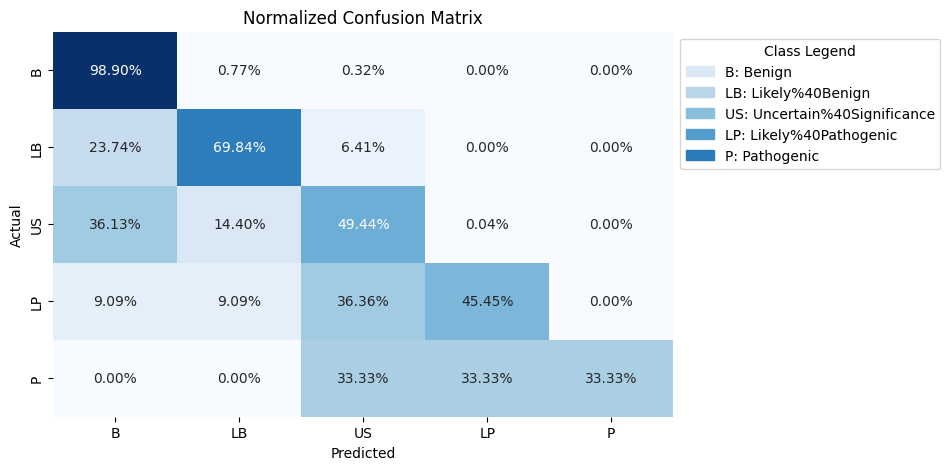

Fitting Model with unweighted loss, greater==better: False, SMOTE with cleaning
Best Parameters:  {'verbose': False, 'learning_rate': 0.01, 'l2_leaf_reg': 10, 'depth': 10}
Best Custom Score:  -33294.2
Confusion Matrix:


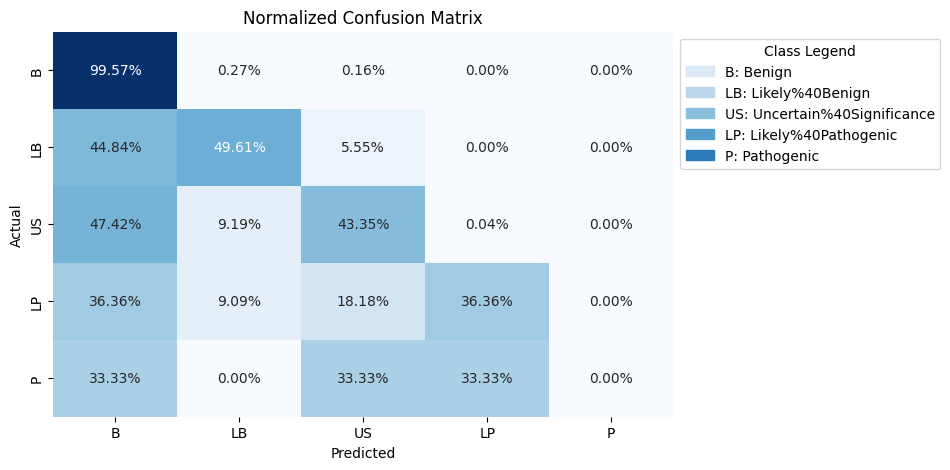

Fitting Model with weighted loss, greater==better: False, SMOTE with cleaning
Best Parameters:  {'verbose': False, 'learning_rate': 0.03, 'l2_leaf_reg': 10, 'depth': 10}
Best Custom Score:  -25208.445395752417
Confusion Matrix:


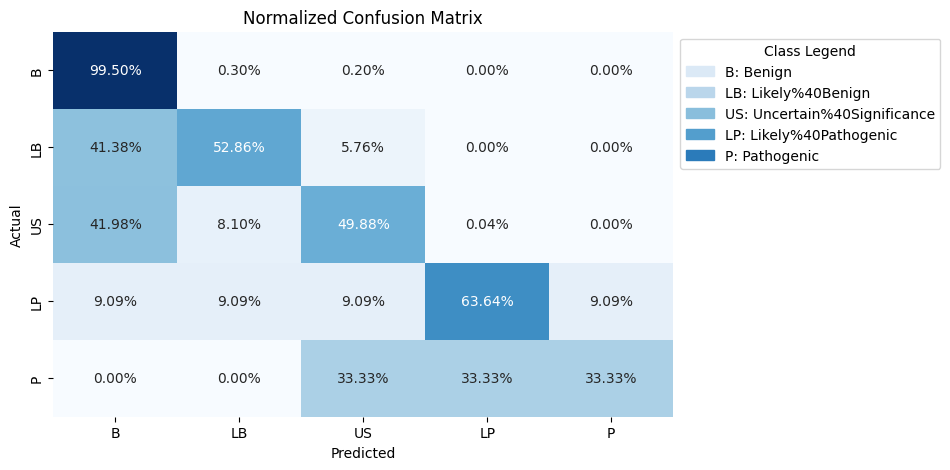

In [19]:
losses = [("unweighted", custom_loss_func), ("weighted", custom_loss_func_weighted)]

greater_better = False
classes_to_oversample = [3, 4]
classes_to_undersample = [0]
undersampling_ratios = [200000]
sampling_ratios = [150, 60]

methods = [
    ("None", None, None),
    ("Random OverSampler" , RandomOverSampler(sampling_strategy={class_label: ratio for class_label, ratio in zip(classes_to_oversample, sampling_ratios)}, random_state=42), None),
    ("Random UnderSampling", RandomUnderSampler(sampling_strategy={class_label: ratio for class_label, ratio in zip(classes_to_undersample, undersampling_ratios)}, random_state=42), RandomOverSampler(sampling_strategy={class_label: ratio for class_label, ratio in zip(classes_to_oversample, sampling_ratios)}, random_state=42)),
    ("SMOTE", SMOTE(sampling_strategy={class_label: ratio for class_label, ratio in zip(classes_to_oversample, sampling_ratios)}, random_state=42), None),
    ("SMOTE with cleaning", SMOTE(sampling_strategy={class_label: ratio for class_label, ratio in zip(classes_to_oversample, sampling_ratios)}, random_state=42), NeighbourhoodCleaningRule(sampling_strategy='auto', n_neighbors=7)),
]

param_grid = {
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5, 10],
    "verbose": [False]
}

for method_name, method, neighborhood_cleaning in methods:
    for loss_name, my_loss in losses:
        print(f"Fitting Model with {loss_name} loss, greater==better: {greater_better}, {method_name}")

        custom_scorer = make_scorer(my_loss, greater_is_better=greater_better)
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        classifier = CatBoostClassifier(random_state=42)

        if method_name == 'None':
            X_resampled_cleaned, y_resampled_cleaned = X_train, y_train

        elif method_name == "SMOTE with cleaning":
            X_resampled, y_resampled = method.fit_resample(X_train, y_train)
            X_resampled_cleaned, y_resampled_cleaned = neighborhood_cleaning.fit_resample(X_resampled, y_resampled)

        elif method_name == "Random UnderSampling":
            X_resampled, y_resampled = method.fit_resample(X_train, y_train)
            X_resampled_cleaned, y_resampled_cleaned = neighborhood_cleaning.fit_resample(X_resampled, y_resampled)
            
        else:
            X_resampled_cleaned, y_resampled_cleaned = method.fit_resample(X_train, y_train)

        stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        halving_search = HalvingRandomSearchCV(
            classifier,
            param_distributions=param_grid,
            scoring=custom_scorer,
            cv=stratified_kfold,
            factor=2,
            resource='n_samples',
            random_state=42
        )

        halving_search.fit(X_resampled_cleaned, y_resampled_cleaned)

        print("Best Parameters: ", halving_search.best_params_)
        print("Best Custom Score: ", halving_search.best_score_)
        print("Confusion Matrix:")

        best_params = halving_search.best_params_
        best_classifier = CatBoostClassifier(**best_params, random_state=42)
        best_classifier.fit(X_resampled_cleaned, y_resampled_cleaned)
        y_pred = best_classifier.predict(X_val)
        get_confusion_matrix_plot(y_val, y_pred, inverted_mapping)

#### Ensamble

Fitting Model with unweighted loss, greater==better: False, None
Best Parameters:  {'replacement': True, 'n_estimators': 25}
Best Custom Score:  -89.0
Confusion Matrix:


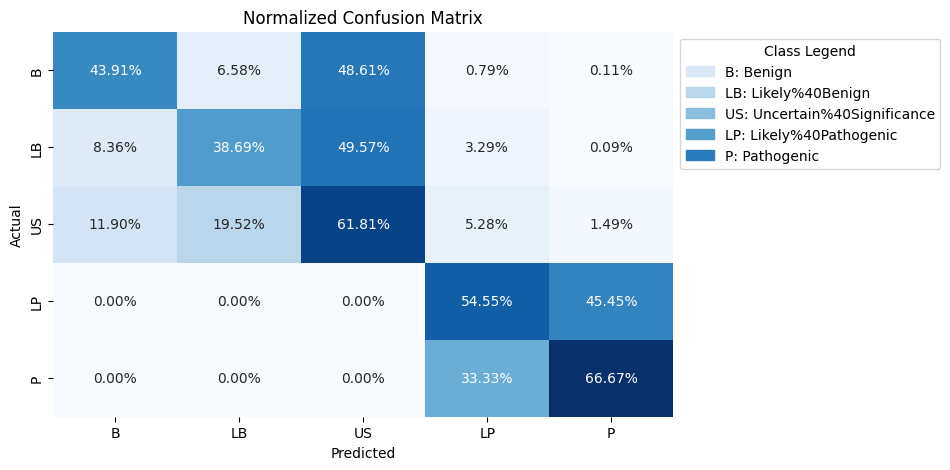

Fitting Model with weighted loss, greater==better: False, None
Best Parameters:  {'replacement': True, 'n_estimators': 25}
Best Custom Score:  -34.02490312650486
Confusion Matrix:


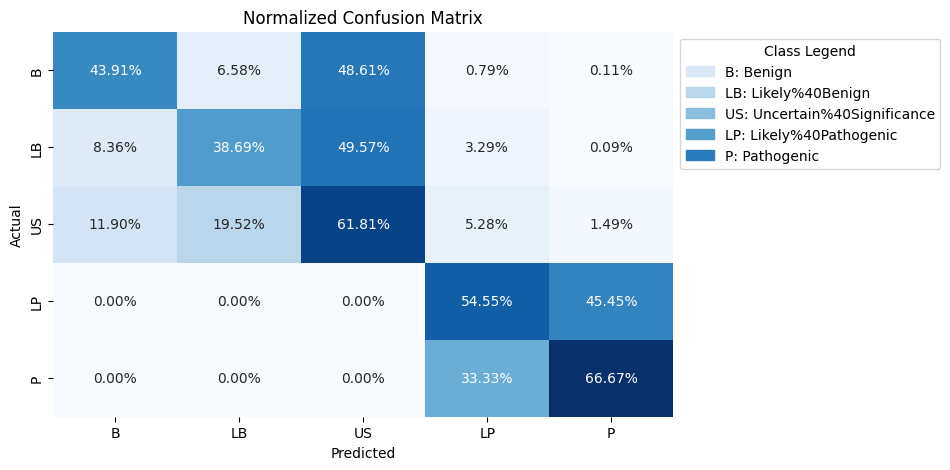

Fitting Model with unweighted loss, greater==better: False, Random OverSampler
Best Parameters:  {'replacement': True, 'n_estimators': 100}
Best Custom Score:  -148.8
Confusion Matrix:


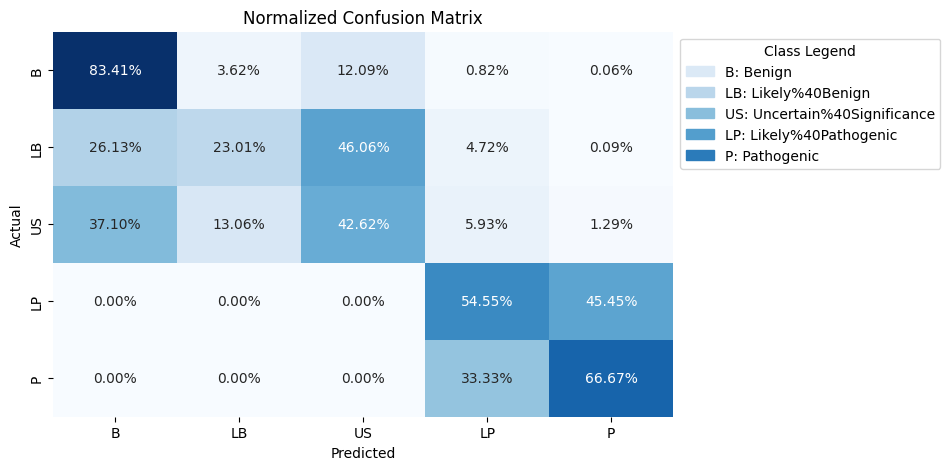

Fitting Model with weighted loss, greater==better: False, Random OverSampler
Best Parameters:  {'replacement': False, 'n_estimators': 100}
Best Custom Score:  -45.03884750919228
Confusion Matrix:


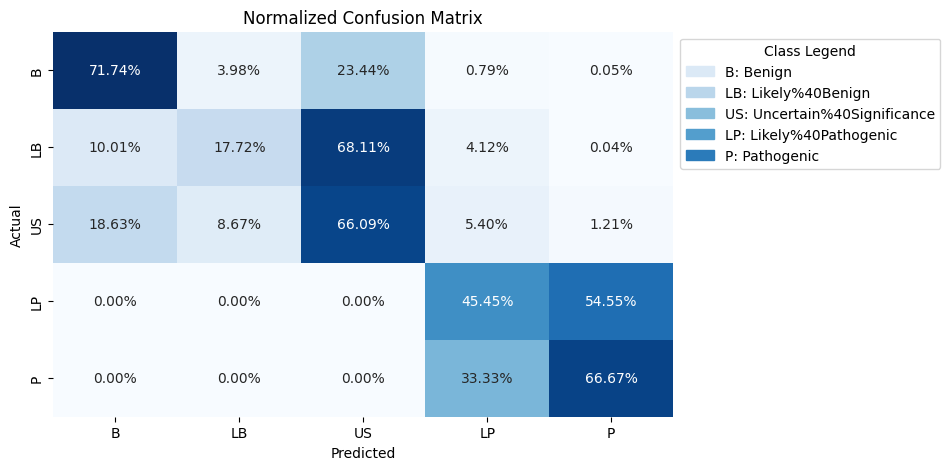

Fitting Model with unweighted loss, greater==better: False, Random UnderSampling
Best Parameters:  {'replacement': True, 'n_estimators': 15}
Best Custom Score:  -316.2
Confusion Matrix:


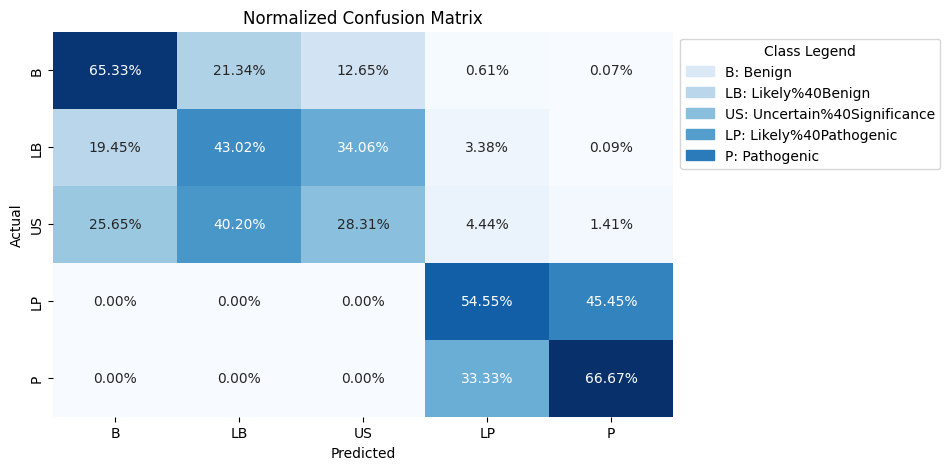

Fitting Model with weighted loss, greater==better: False, Random UnderSampling
Best Parameters:  {'replacement': True, 'n_estimators': 100}
Best Custom Score:  -60.64945656331994
Confusion Matrix:


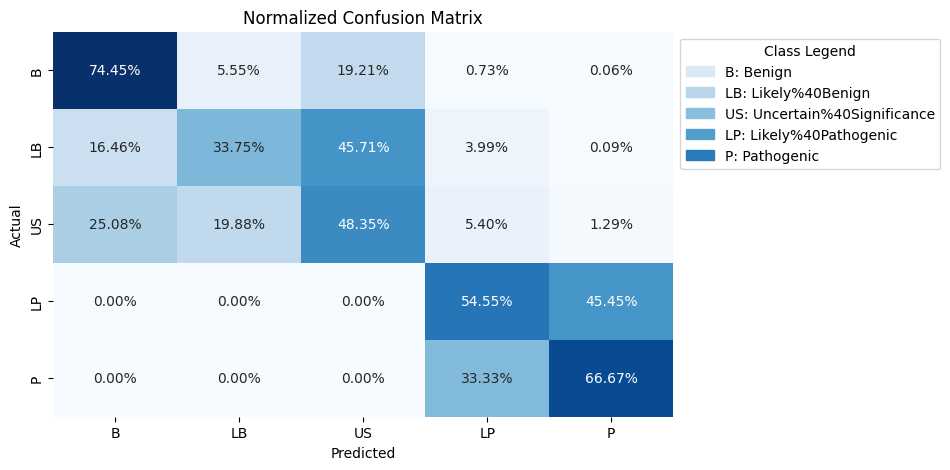

Fitting Model with unweighted loss, greater==better: False, SMOTE
Best Parameters:  {'replacement': True, 'n_estimators': 100}
Best Custom Score:  -148.8
Confusion Matrix:


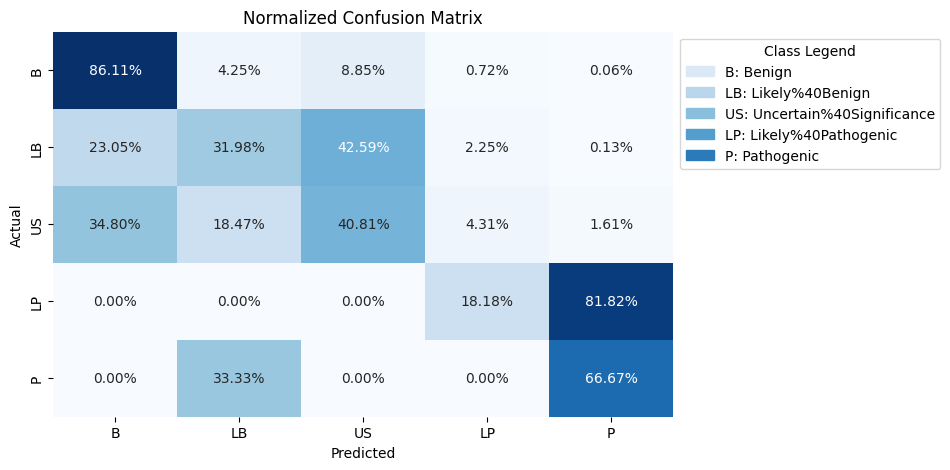

Fitting Model with weighted loss, greater==better: False, SMOTE
Best Parameters:  {'replacement': False, 'n_estimators': 100}
Best Custom Score:  -45.03884750919228
Confusion Matrix:


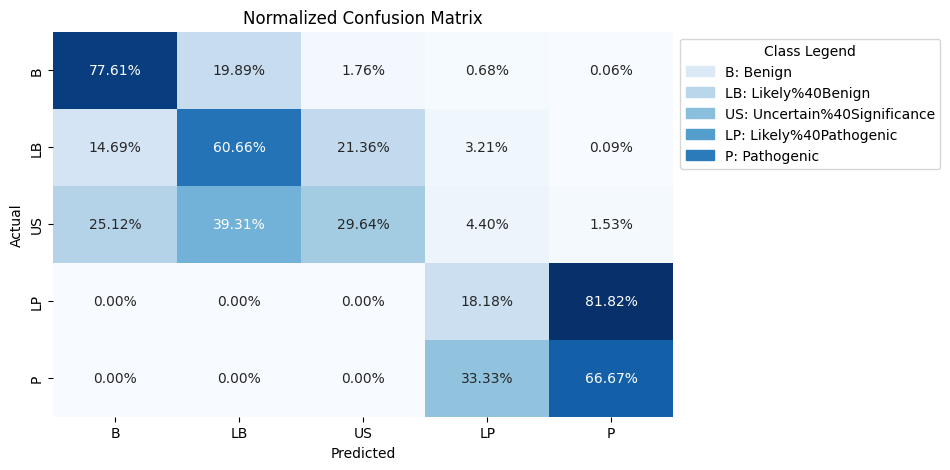

Fitting Model with unweighted loss, greater==better: False, SMOTE with cleaning
Best Parameters:  {'replacement': True, 'n_estimators': 100}
Best Custom Score:  -122.0
Confusion Matrix:


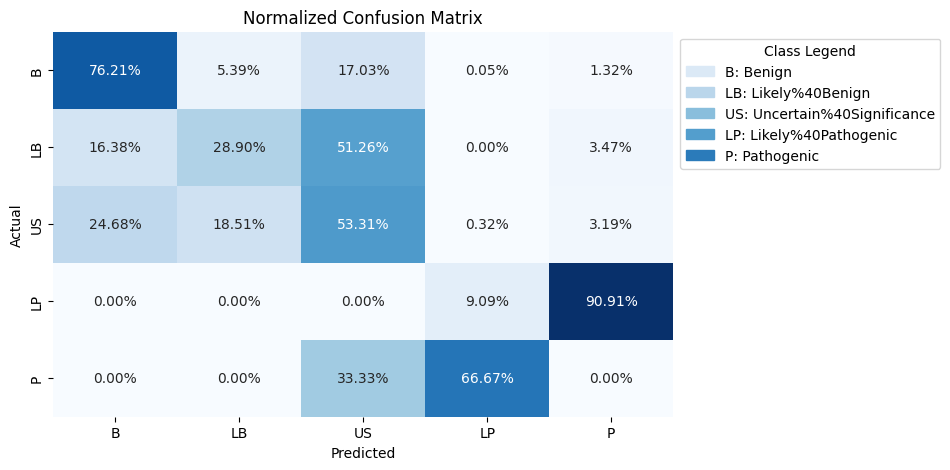

Fitting Model with weighted loss, greater==better: False, SMOTE with cleaning
Best Parameters:  {'replacement': True, 'n_estimators': 100}
Best Custom Score:  -24.520127634486514
Confusion Matrix:


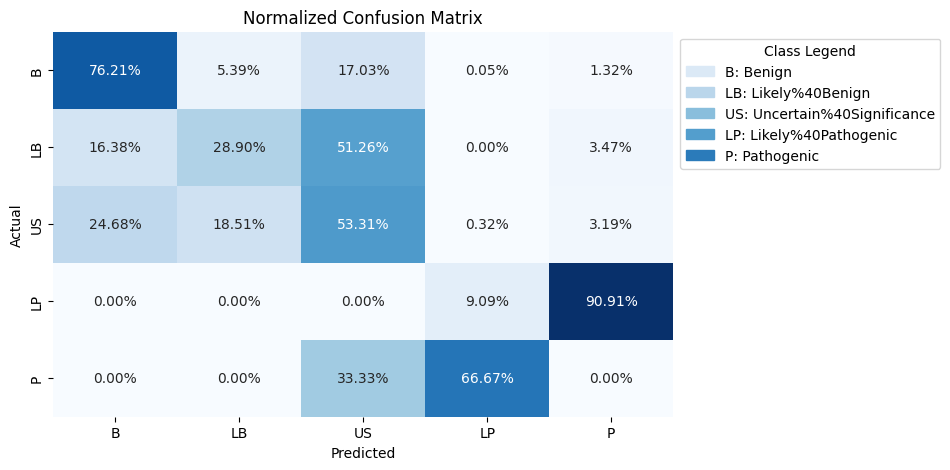

In [20]:
losses = [("unweighted", custom_loss_func), ("weighted", custom_loss_func_weighted)]

greater_better = False
classes_to_oversample = [3, 4]
classes_to_undersample = [0]
undersampling_ratios = [200000]
sampling_ratios = [150, 60]

methods = [
    ("None", None, None),
    ("Random OverSampler" , RandomOverSampler(sampling_strategy={class_label: ratio for class_label, ratio in zip(classes_to_oversample, sampling_ratios)}, random_state=42), None),
    ("Random UnderSampling", RandomUnderSampler(sampling_strategy={class_label: ratio for class_label, ratio in zip(classes_to_undersample, undersampling_ratios)}, random_state=42), RandomOverSampler(sampling_strategy={class_label: ratio for class_label, ratio in zip(classes_to_oversample, sampling_ratios)}, random_state=42)),
    ("SMOTE", SMOTE(sampling_strategy={class_label: ratio for class_label, ratio in zip(classes_to_oversample, sampling_ratios)}, random_state=42), None),
    ("SMOTE with cleaning", SMOTE(sampling_strategy={class_label: ratio for class_label, ratio in zip(classes_to_oversample, sampling_ratios)}, random_state=42), NeighbourhoodCleaningRule(sampling_strategy='auto', n_neighbors=7)),
]

param_grid = {
    'n_estimators': [2, 5, 10, 15, 20, 25, 30, 100],
    'replacement': [False, True]
}

for method_name, method, neighborhood_cleaning in methods:
    for loss_name, my_loss in losses:
        print(f"Fitting Model with {loss_name} loss, greater==better: {greater_better}, {method_name}")

        custom_scorer = make_scorer(my_loss, greater_is_better=greater_better)
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        classifier = EasyEnsembleClassifier(random_state=42)

        if method_name == 'None':
            X_resampled_cleaned, y_resampled_cleaned = X_train, y_train

        elif method_name == "SMOTE with cleaning":
            X_resampled, y_resampled = method.fit_resample(X_train, y_train)
            X_resampled_cleaned, y_resampled_cleaned = neighborhood_cleaning.fit_resample(X_resampled, y_resampled)

        elif method_name == "Random UnderSampling":
            X_resampled, y_resampled = method.fit_resample(X_train, y_train)
            X_resampled_cleaned, y_resampled_cleaned = neighborhood_cleaning.fit_resample(X_resampled, y_resampled)
            
        else:
            X_resampled_cleaned, y_resampled_cleaned = method.fit_resample(X_train, y_train)

        stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        halving_search = HalvingRandomSearchCV(
            classifier,
            param_distributions=param_grid,
            scoring=custom_scorer,
            cv=stratified_kfold,
            factor=2,
            resource='n_samples',
            random_state=42
        )

        halving_search.fit(X_resampled_cleaned, y_resampled_cleaned)

        print("Best Parameters: ", halving_search.best_params_)
        print("Best Custom Score: ", halving_search.best_score_)
        print("Confusion Matrix:")

        best_params = halving_search.best_params_
        best_classifier = EasyEnsembleClassifier(**best_params, random_state=42)
        best_classifier.fit(X_resampled_cleaned, y_resampled_cleaned)
        y_pred = best_classifier.predict(X_val)
        get_confusion_matrix_plot(y_val, y_pred, inverted_mapping)

### Final Model

In [4]:
EE15 = get_dataset("data/", samples=["EE_015"], file_type="both", option_csq="potential", 
            options_genotype=["potential", "all"], with_default=True)
EE50 = get_dataset("data/", samples=["EE_050"], file_type="both", option_csq="potential", 
            options_genotype=["potential", "all"], with_default=True)
EE69 = get_dataset("data/", samples=["EE_069"], file_type="both", option_csq="potential", 
            options_genotype=["potential", "all"], with_default=True)

In [5]:
EE15['patient'] = 'EE15'
EE50['patient'] = 'EE50'
EE69['patient'] = 'EE69'

In [6]:
custom_mapping = {
    'Benign': 0,
    'Likely%40Benign': 1,
    'Uncertain%40Significance': 2,
    'Likely%40Pathogenic': 3,
    'Pathogenic': 4
}

target_column = "ACMG_class"
df = pd.concat([EE15, EE50, EE69])

df = df.loc[:, ~df.columns.duplicated()]
preprocessed_df = preprocess(df)

encoded_df, encoders, target_mapping = encode(preprocessed_df, target_column, custom_mapping)

In [7]:
encoded_df = encoded_df.drop_duplicates()
test_patient = encoded_df[encoded_df['patient'] == 0].copy()
test_patient = test_patient.sample(frac=1, random_state=42).reset_index(drop=True)
encoded_df = encoded_df[encoded_df['patient'] != 0]

X_test = test_patient.drop(columns=["patient", target_column])
y_test = test_patient[target_column]

X = encoded_df.drop(columns = ["patient", target_column])
y = encoded_df[target_column]

In [13]:
inverted_mapping = invert_dict(target_mapping)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [29]:
model = CatBoostClassifier(random_state=42, verbose = False)
sample_weights = compute_sample_weight('balanced', y_train)
model.fit(X_train, y_train, sample_weight = sample_weights)

#### Train set

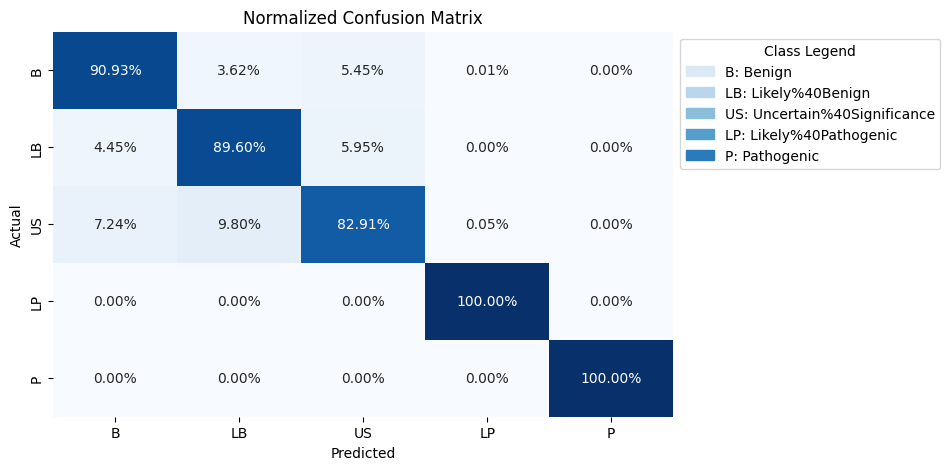

In [14]:
y_pred = model.predict(X_train)
get_confusion_matrix_plot(y_train, y_pred, inverted_mapping)

#### Validation set

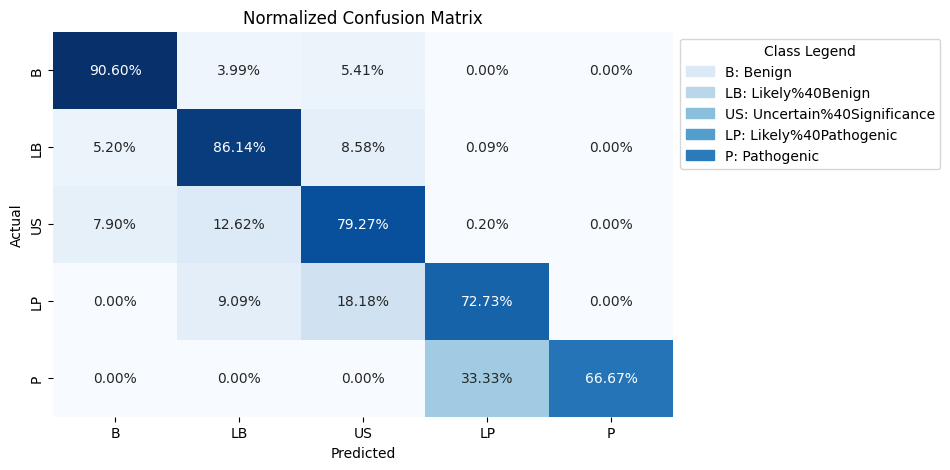

In [15]:
y_pred = model.predict(X_val)
get_confusion_matrix_plot(y_val, y_pred, inverted_mapping)

#### Test set

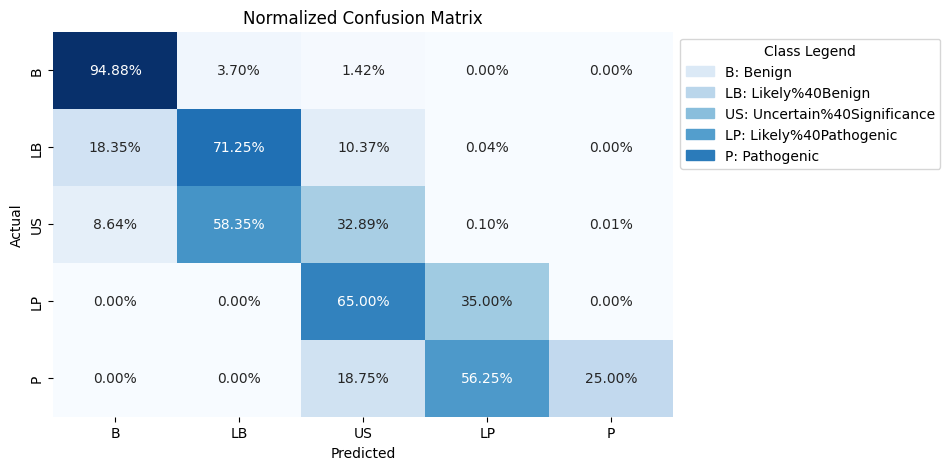

In [16]:
y_pred = model.predict(X_test)
get_confusion_matrix_plot(y_test, y_pred, inverted_mapping)

### Final Model Save

Partial Model

In [87]:
import pickle

with open('pathogenicity_model.pkl', 'wb') as file:
    pickle.dump(model, file)

Full Model

In [33]:
scaler = RobustScaler()
X = scaler.fit_transform(X)
full_model = CatBoostClassifier(random_state=42, verbose = False)
sample_weights = compute_sample_weight('balanced', y)
full_model.fit(X, y, sample_weight = sample_weights)

y_pred = model.predict(X)
get_confusion_matrix_plot(y, y_pred, inverted_mapping)

with open('full_pathogenicity_model.pkl', 'wb') as file:
    pickle.dump(model, file)

### Explainability

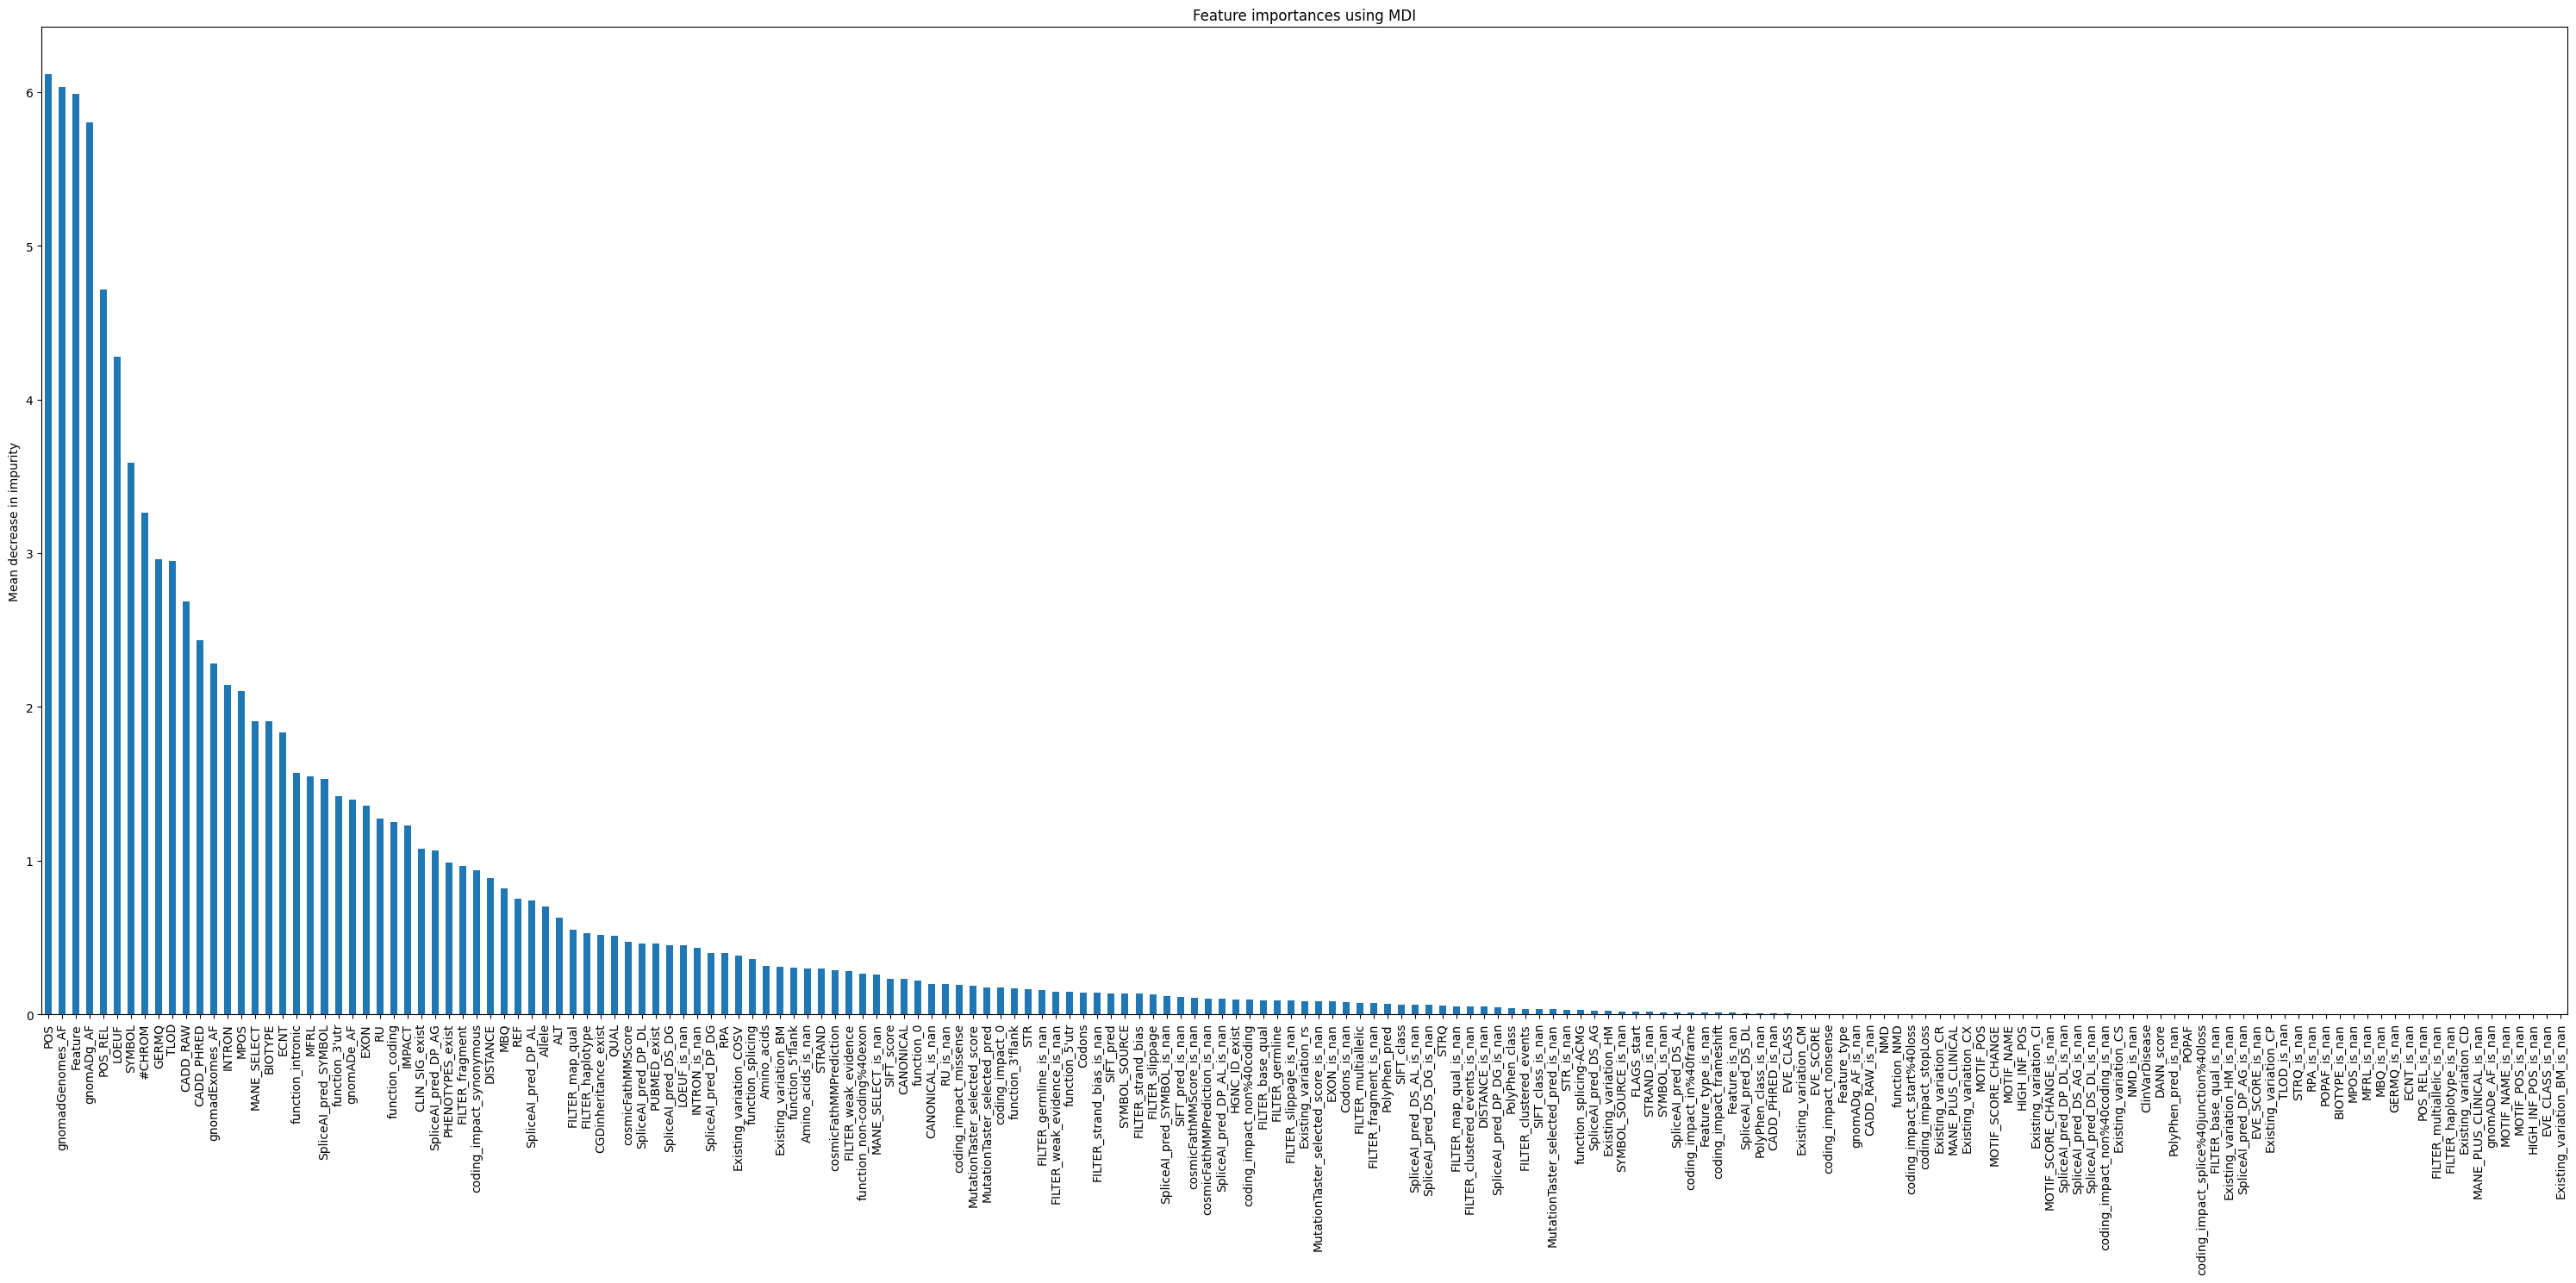

In [30]:
from catboost import CatBoostClassifier, Pool, cv
import matplotlib.pyplot as plt
import pandas as pd

train_pool = Pool(data=X_train, label=y_train)
feature_importance = model.get_feature_importance(data=train_pool, type='FeatureImportance')
feature_importance = pd.Series(feature_importance, index=encoded_df.drop(columns=["patient", "ACMG_class"]).columns)
feature_importance = feature_importance.sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(30, 15))
feature_importance.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

In [31]:
import dalex as dx

exp = dx.Explainer(model, X_train, y_train)
exp.predict_parts(X_train[0], type='shap').plot(max_vars=5)

Preparation of a new explainer is initiated

  -> data              : numpy.ndarray converted to pandas.DataFrame. Columns are set as string numbers.
  -> data              : 307734 rows 183 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 307734 values
  -> model_class       : catboost.core.CatBoostClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x000001B9DE0B8040> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 3.63e-07, mean = 0.124, max = 0.998
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.997, mean = 0.0895, max = 4.0
  -> model_info        : package catboost

A new explainer has been created!
